<div align="center"><img src="images/hitchcock.png" width=450></div>

# Apple Brand Sentiment at South by Southwest

Nick Gigliotti

[ndgigliotti@gmail.com](ndgigliotti@gmail.com)

[github.com/ndgigliotti](https://github.com/ndgigliotti)

# Business Problem

Apple (fictitiously) wants me to create an explanatory model of positive and negative sentiment in tweets related to the South by Southwest (SXSW) conference in Austin, Texas, 2011. They are specifically interested in what people think about their company, products, and marketing efforts. They've provided me with a labeled Twitter dataset, obtained by one of my coworkers. My objectives are:

1. Build a sentiment classifier for explanatory purposes.
2. Find out what people are saying about Apple (at South by Southwest, 2011).
3. Make some PR recommendations for the period immediately following the event.

# Imports

In [1]:
import re
import string
import json
from pprint import pprint
from functools import partial

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import (
    classification_report,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)
from imblearn.over_sampling import (
    SMOTE,
    RandomOverSampler,
    ADASYN,
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import bert_sklearn
from bert_sklearn import BertClassifier
import lime
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

10/29/2021 18:44:18 - INFO - blib2to3.pgen2.driver -   Generating grammar tables from C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\blib2to3\Grammar.txt
10/29/2021 18:44:18 - INFO - blib2to3.pgen2.driver -   Writing grammar tables to C:\Users\ndgig\AppData\Local\black\black\Cache\21.9b0\Grammar3.8.12.final.0.pickle
10/29/2021 18:44:18 - INFO - blib2to3.pgen2.driver -   Writing failed: [Errno 2] No such file or directory: 'C:\\Users\\ndgig\\AppData\\Local\\black\\black\\Cache\\21.9b0\\tmpbhav7xxu'
10/29/2021 18:44:18 - INFO - blib2to3.pgen2.driver -   Generating grammar tables from C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\blib2to3\PatternGrammar.txt
10/29/2021 18:44:18 - INFO - blib2to3.pgen2.driver -   Writing grammar tables to C:\Users\ndgig\AppData\Local\black\black\Cache\21.9b0\PatternGrammar3.8.12.final.0.pickle
10/29/2021 18:44:18 - INFO - blib2to3.pgen2.driver -   Writing failed: [Errno 2] No such file or directory: 'C:\\Users\\ndgig\\AppData\\Local\\black\

<IPython.core.display.Javascript object>

## My `tools` Package

I put a lot of time and energy into developing my own tools for analysis. It's probably my favorite part of this kind of work, and I (admittedly) tend to get carried away with it. I developed a lot in `tools.language` and `tools.sklearn.vectorizers` for this project in particular. I'll discuss important developments as they come up.

In [2]:
# Import my modules
from ndg_tools import cleaning, plotting, outliers, utils, language as lang
from ndg_tools.sklearn.vectorizers import FreqVectorizer, VaderVectorizer
from ndg_tools.sklearn import selection

FIT_BERT = False

# Run time-consuming grid searches
RUN_SWEEPS = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<IPython.core.display.Javascript object>

# Overview of Dataset
Since Apple is interested in sentiment analysis on Twitter, I've found a Twitter dataset with crowdsourced sentiment labels. It comes from [CrowdFlower](https://data.world/crowdflower), which has released other similar datasets.

The tweets are related to South by Southwest, an annual conference and arts festival in Austin, Texas. They are from 2011, when Apple launched the iPad 2.

It has only three features: the tweet text, the brand object of the sentiment, and the sentiment. It has only about 9,100 tweets.

In [3]:
df = pd.read_csv("data/crowdflower_tweets.csv", encoding="latin1")
df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

<IPython.core.display.Javascript object>

The dataset contains one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing the dataset. I'm going to rename those before I do anything else.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [5]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

text   object_of_emotion  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [6]:
cleaning.show_uniques(df)

<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [7]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [8]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\pandas\core\arrays\categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


<IPython.core.display.Javascript object>

The 'Neutral' category dominates the distribution, and 'Negative' is very underrepresented. 'Uncertain' is fortunately a very small 2% of the samples. That's good, because it's completely useless to me.

(0.0, 0.75)

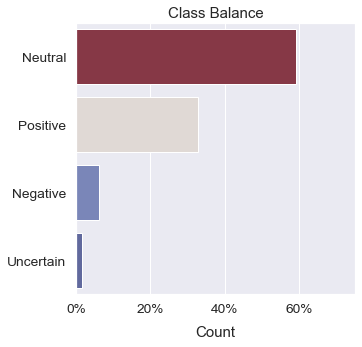

<IPython.core.display.Javascript object>

In [9]:
ax = plotting.countplot(df["emotion"], normalize=True)
ax.set(title="Class Balance")
ax.set_xlim((0, 0.75))

I drop the uncertain category, which doesn't have any clear value. I will have to cope with this imbalance later.

In [10]:
# Remove 'Uncertain' and 'Neutral' categories
df["emotion"] = df["emotion"].cat.remove_categories(["Uncertain", "Neutral"])
df

text object_of_emotion  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...            iPhone   
1     @jessedee Know about @fludapp ? Awesome iPad/i...           iOS App   
2     @swonderlin Can not wait for #iPad 2 also. The...              iPad   
3     @sxsw I hope this year's festival isn't as cra...           iOS App   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...            Google   
...                                                 ...               ...   
9088                      Ipad everywhere. #SXSW {link}              iPad   
9089  Wave, buzz... RT @mention We interrupt your re...               NaN   
9090  Google's Zeiger, a physician never reported po...               NaN   
9091  Some Verizon iPhone customers complained their...               NaN   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...               NaN   

       emotion  
0     Negative  
1     Positive  
2     Positive  
3     Negative  
4     Positive  
...        ...  
9088  Positive  
9089       NaN  
9090       NaN  
9091       NaN  
9092       NaN  

[9093 rows x 3 columns]

<IPython.core.display.Javascript object>

'images\\class_balance.svg'

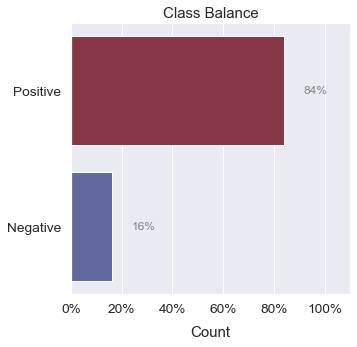

<IPython.core.display.Javascript object>

In [11]:
# Plot class balance
ax = plotting.countplot(df.emotion, normalize=True)
ax.set(title="Class Balance")
plotting.annot_bars(ax, format_spec="{x:.0%}")
ax.set_xlim((0, 1.1))
plotting.save(ax.figure, "images/class_balance.svg")

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [12]:
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion  5802   63.81     9    0.10   22   0.24
emotion            5545   60.98     2    0.02   22   0.24
text                  1    0.01  9065   99.69   22   0.24

<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [13]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion   357   10.06     9    0.25    9   0.25
text                  0    0.00  3539   99.75    9   0.25
emotion               0    0.00     2    0.06    9   0.25

<IPython.core.display.Javascript object>

Since I don't have anymore null 'emotion' values, I'll go ahead and create a binary 'target' feature.

In [14]:
df["target"] = df["emotion"].replace({"Positive": 1, "Negative": 0}).astype(np.uint8)
df["target"]

0       0
1       1
2       1
3       0
4       1
       ..
9077    1
9079    1
9080    0
9085    1
9088    1
Name: target, Length: 3548, dtype: uint8

<IPython.core.display.Javascript object>

In [15]:
emotion_without_object = cleaning.null_rows(df)
display(emotion_without_object.head(), emotion_without_object.shape)

text object_of_emotion  \
46   Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...               NaN   
64   Again? RT @mention Line at the Apple store is ...               NaN   
68   Boooo! RT @mention Flipboard is developing an ...               NaN   
103  Know that &quot;dataviz&quot; translates to &q...               NaN   
112  Spark for #android is up for a #teamandroid aw...               NaN   

      emotion  target  
46   Positive       1  
64   Negative       0  
68   Negative       0  
103  Negative       0  
112  Positive       1

(357, 4)

<IPython.core.display.Javascript object>

Looks like some of the NaN values are associated with a positive or negative emotion. Also, it's important to note that some retweets, e.g. 64, 68, have sentimental content beyond that of the original tweet.

In [16]:
lang.readable_sample(
    emotion_without_object.loc[emotion_without_object.target.astype(np.bool_), "text"],
    random_state=456,
)

|      | text                                                                                                                                           |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------|
| 6606 | RT @mention RT @mention Shiny new @mention @mention @eightbit apps, a new @garyvee book, pop-up iPad 2 stores... #SXSW is Christmas for nerds. |
| 4164 | Mad long line for Google party at Maggie Mae's. Hope it's worth it.. but with 80s theme I am very optimistic #sxsw                             |
| 3020 | Apple offers original iPad donation program {link} #entry #friends #house #sxsw                                                                |
| 8114 | #touchingstories giving us the background to STARTING. Great to hear after yesterday's presos on #uncertainty #iPad and/or #tablet #SXSW       |
|  555 | I have my golden tickets f 4sq party Day after the real party #Redbullbpm with Felix da Housecat playing on iPad! #SXSW  {link}                |
| 5501 | RT @mention At #sxsw even the cabbies are tech savvy. That's his iPhone streaming twitter. @mention  {link}                                    |
| 6676 | RT @mention Soundtrckr featured by @mention @mention as a Must-have for #SXSW {link}                                                           |
|  157 | @mention  #SXSW LonelyPlanet Austin guide for #iPhone is free for a limited time {link} #lp #travel                                            |
| 5019 | Here he comes ladies! @mention  @mention  RT @mention I'll be at Austin Convention Center w/  @mention showing my  iPhone game. #SXSW          |
| 8025 | Someone asks Leo about an iPad 2 at #SXSW, he says 'Email me, I'll send you one free'. O.o                                                     |

<IPython.core.display.Javascript object>

These are positive tweets which are missing a brand label. Many of them seem positive&mdash;some towards a brand and some not. The original features names were 'emotion_in_tweet_is_directed_at' and 'is_there_an_emotion_directed_at_a_brand_or_product', which is not consistent with brandless positivity.

In [17]:
# Create regex for finding each brand
re_apple = r"ipad\s*\d?\s*app|ipad|iphone\s*\d?\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find brand/product name occurrences for each brand
findings = lang.locate_patterns(
    [re_apple, re_google],
    docs=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

ipad           125
google         122
apple           76
iphone          57
android         19
iphone app       8
ipad app         4
android app      1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [18]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

original    match  score
46    ios app  iOS App    100
6220   iphone   iPhone    100
6202   iphone   iPhone    100
6180    apple    Apple    100
6180     ipad     iPad    100
...       ...      ...    ...
3055     ipad     iPad    100
3055     ipad     iPad    100
3040     ipad     iPad    100
3269  android  Android    100
9054     ipad     iPad    100

[412 rows x 3 columns]

<IPython.core.display.Javascript object>

In [19]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=4564)

text object_of_emotion  \
646   ÛÏ@mention I'll be at the Austin Convention C...            iPhone   
7285  Google showing off google places with hotpot a...            Google   
4870  Excited to say that I haven't used Foursquare,...            Google   
1805  #sxsw: #15slides: Gruber: keeps on desk Apple ...             Apple   
4976  @mention Oh, oh, oh! Does the iPad come with m...              iPad   
6996  RT @mention Zazzle is officially at #SXSW! Com...            iPhone   
4536  Whoa - line for ipad2 is 3blks long!!! #apple ...              iPad   
2572  That sounds...fantastic. RT @mention At the Go...            Google   
3861  Bad news is it costs $1,000? RT @mention Louis...           iOS App   
7990  Apple to sell iPads in &quot;pop-up&quot; Appl...              iPad   

       emotion  target  
646   Positive       1  
7285  Positive       1  
4870  Positive       1  
1805  Positive       1  
4976  Positive       1  
6996  Positive       1  
4536  Positive       1  
2572  Positive       1  
3861  Negative       0  
7990  Positive       1

<IPython.core.display.Javascript object>

In [20]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

Here's a look at the distributions.

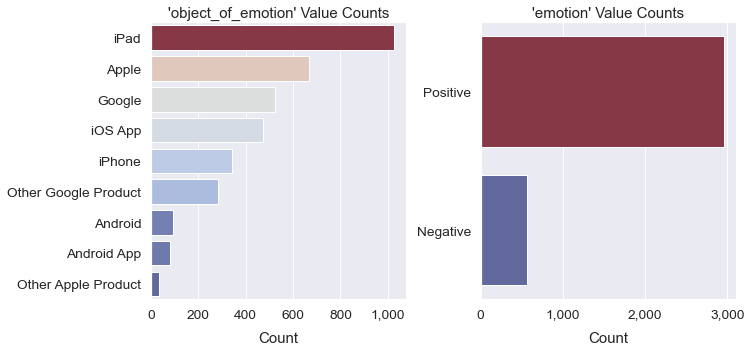

<IPython.core.display.Javascript object>

In [21]:
fig = plotting.countplot(df.select_dtypes("category"))

## Initial Preprocessing

I do some minimal preprocessing on the text before I begin modeling. I transliterate the symbols to ASCII in order to remove accents and remove strange symbols which cannot be decoded properly. Unfortunately there are a lot of strange symbols in this dataset which I can't find a way to decode. I also decode HTML entities like `&mdash;` or `&amp;`, and remove extra space.

In [22]:
df["text"] = lang.force_ascii(df["text"])
df["text"] = lang.decode_html_entities(df["text"])
df["text"] = lang.strip_extra_space(df["text"])
df["text"]

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9077    @mention your PR guy just convinced me to swit...
9079    "papyrus...sort of like the ipad" - nice! Lol!...
9080    Diller says Google TV "might be run over by th...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                        Ipad everywhere. #SXSW {link}
Name: text, Length: 3524, dtype: object

<IPython.core.display.Javascript object>

## Duplicates
There are several duplicate rows, and even more when only the text is considered. I don't want to get rid of all retweets, but I do want to get rid of those which don't have novel content.

In [23]:
cleaning.dup_rows(df["text"]).sort_values()

7       #SXSW is just starting, #CTIA is around the co...
3962    #SXSW is just starting, #CTIA is around the co...
1690    #pubcamp #kirkus #sxsw download Qrank on your ...
1691    #pubcamp #kirkus #sxsw download Qrank on your ...
466        Before It Even Begins, Apple Wins #SXSW {link}
468        Before It Even Begins, Apple Wins #SXSW {link}
9       Counting down the days to #sxsw plus strong Ca...
2559    Counting down the days to #sxsw plus strong Ca...
7493    Google Maps Street View car sighting!!! #SXSW ...
7492    Google Maps Street View car sighting!!! #SXSW ...
812     Google to Launch Major New Social Network Call...
813     Google to Launch Major New Social Network Call...
17      I just noticed DST is coming this weekend. How...
8483    I just noticed DST is coming this weekend. How...
8747    Need to buy an iPad2 while I'm in Austin at #s...
20      Need to buy an iPad2 while I'm in Austin at #s...
4897    Oh. My. God. The #SXSW app for iPad is pure, u...
21      Oh. My

<IPython.core.display.Javascript object>

In [24]:
dups = df["text"].str.replace(r"\bRT\s+", "", regex=True).duplicated()
display(len(df))
df = df.loc[~dups].copy()
df

3524

text     object_of_emotion  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...                iPhone   
1     @jessedee Know about @fludapp ? Awesome iPad/i...               iOS App   
2     @swonderlin Can not wait for #iPad 2 also. The...                  iPad   
3     @sxsw I hope this year's festival isn't as cra...               iOS App   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...                Google   
...                                                 ...                   ...   
9077  @mention your PR guy just convinced me to swit...                iPhone   
9079  "papyrus...sort of like the ipad" - nice! Lol!...                  iPad   
9080  Diller says Google TV "might be run over by th...  Other Google Product   
9085  I've always used Camera+ for my iPhone b/c it ...               iOS App   
9088                      Ipad everywhere. #SXSW {link}                  iPad   

       emotion  target  
0     Negative       0  
1     Positive       1  
2     Positive       1  
3     Negative       0  
4     Positive       1  
...        ...     ...  
9077  Positive       1  
9079  Positive       1  
9080  Negative       0  
9085  Positive       1  
9088  Positive       1  

[3510 rows x 4 columns]

<IPython.core.display.Javascript object>

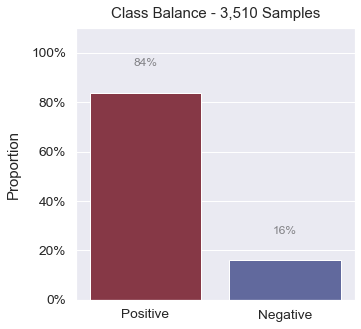

<IPython.core.display.Javascript object>

In [25]:
ax = plotting.countplot(df["emotion"], normalize=True, orient="v")
ax.set_title(f"Class Balance - {len(df):,.0f} Samples", pad=10)
ax.set_ylabel("Proportion")
plotting.annot_bars(ax, format_spec="{x:.0%}", orient="v")
ax.set_ylim(0, 1.1)
ax.figure.savefig("images/class_balance.svg", bbox_inches="tight")

Next, I save the data for use in `exploratory.ipynb`, where I conduct an exploratory analysis. I'll proceed directly to modeling in this notebook.

In [26]:
df.to_json("data/processed_tweets.json")

<IPython.core.display.Javascript object>

# Modeling

## Train-Test-Split

I perform the train-test split which I'll use throughout my modeling process.

In [27]:
# Define X and y
X = df["text"].copy()
y = df["target"].copy()

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=15,
    stratify=y,
    shuffle=True,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2632,), (2632,), (878,), (878,))

<IPython.core.display.Javascript object>

## Preparing the Diagnostics

I choose to optimize macro average recall in order to compensate for the class imbalance. It is equivalent to Scikit-Learn's "balanced accuracy" metric, which is equivalent to the arithmetic mean of recall scores. I also plot a confusion matrix and precision-recall curve for each model. Confusion matrices are one of the best all-around diagnostic plots for classification, and precision-recall curves are particularly useful when dealing with class imbalance.

I'll need to define a couple functions for diagnostic purposes. I'll start by defining a function that returns a standard classification report as a `DataFrame`.

In [28]:
def classif_report(
    y_true,
    y_pred,
    *,
    labels=[0, 1],
    target_names=None,
    sample_weight=None,
    zero_division=0,
):
    """Returns a classification report as a DataFrame."""
    if target_names is not None:
        target_names = [x.lower() for x in target_names]
    report = classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=target_names,
        sample_weight=sample_weight,
        output_dict=True,
        zero_division=zero_division,
    )
    return pd.DataFrame(report)

<IPython.core.display.Javascript object>

I also define a function for evaluating each model I train. It will get the classification report, highlight my target metric (macro average recall), plot a confusion matrix, and plot precision-recall curves.

In [29]:
def eval_model(
    estimator,
    name,
    X_test=X_test,
    y_test=y_test,
    display_labels=["Negative", "Positive"],
    highlight=("recall", "macro avg"),
    compare_curves=None,
    palette="deep",
    desat=0.85,
):
    # Make predictions
    y_true = y_test
    y_pred = estimator.predict(X_test)
    y_proba = estimator.predict_proba(X_test)

    # Get classification report (table)
    rep = classif_report(y_true, y_pred, target_names=display_labels)

    # Plot confusion matrix
    display_labels = [x.title() for x in display_labels]
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
    cm = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize="true",
        display_labels=display_labels,
        cmap=plotting.get_desat_cmap("Blues", desat=desat),
        colorbar=False,
        ax=ax1,
    )
    ax1.grid(False)
    ax1.set(title=f"{name} Confusion Matrix")

    # Plot main precision-recall curve
    n_colors = 1 if not compare_curves else 1 + len(compare_curves)
    colors = sns.color_palette(palette, n_colors=n_colors, desat=desat)
    prc = PrecisionRecallDisplay.from_predictions(
        y_true,
        y_proba[:, 1],
        pos_label=1,
        name=name,
        ax=ax2,
        c=colors[0],
    )
    # Plot comparison curves
    if compare_curves is not None:
        for color, curve in zip(colors[1:], compare_curves):
            curve.plot(ax2, c=color)
    ax2.set(xlabel="Recall", ylabel="Precision", title=f"{name} Precision-Recall Curve")
    fig.tight_layout()

    # Display classification report, highlighting chosen metric
    display(
        rep.style.background_gradient(
            cmap=plotting.get_desat_cmap("coolwarm"),
            subset=highlight,
            vmin=0.0,
            vmax=1.0,
        )
    )
    # Save the figure
    dst = f"images/{name.lower().replace(' ', '_')}_diagnostics.svg"
    fig.savefig(dst, bbox_inches="tight")
    return rep, cm, prc

<IPython.core.display.Javascript object>

## Dummy Model

I begin by creating a dummy model as an ultimate baseline. Testing the dummy model will reveal how an extremely dumb algorithm performs on the metrics I'm using.

In [30]:
fv = FreqVectorizer()
fv

FreqVectorizer()

<IPython.core.display.Javascript object>

<a id='my-freqvectorizer'></a>

### My `FreqVectorizer`

For vectorization, I'll primarily use my custom `FreqVectorizer`, which is an extension of Scikit-Learn's `TfidfVectorizer` with additional preprocessing options. It's called `FreqVectorizer` to emphasize that, like its parent class, it offers several different word-frequency-based vectorization algorithms. Among these algorithms are term frequency (count) vectorization and TF\*IDF (term frequency * inverse document frequency) vectorization. By default, `FreqVectorizer` is set to perform **count vectorization**.

I'll discuss more details of my `FreqVectorizer` class as they become relevant. Feel free to look through the help page below.

In [31]:
help(FreqVectorizer)

Help on class FreqVectorizer in module ndg_tools.sklearn.vectorizers:

class FreqVectorizer(sklearn.feature_extraction.text.TfidfVectorizer, VectorizerMixin)
 |  FreqVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, decode_html_entities=True, lowercase=True, strip_extra_space=False, strip_numeric=False, strip_non_word=False, strip_punct=False, strip_twitter_handles=False, strip_html_tags=False, limit_repeats=False, uniq_char_thresh=None, mark_negation=False, stemmer=None, preprocessor=None, tokenizer=None, token_pattern='\\b\\w\\w+\\b', analyzer='word', stop_words=None, process_stop_words=True, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm=None, use_idf=False, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of word-frequency features.
 |  
 |  Extends Scikit-Learn's `TfidfVectorizer` with advanced preprocessing optio

<IPython.core.display.Javascript object>

I choose the 'stratified' dummy algorithm, which makes predictions according to the class support. The predictions will be as imbalanced as the classes.

In [32]:
pipe = Pipeline(
    [
        ("vec", fv),
        ("cls", DummyClassifier(strategy="stratified")),
    ],
    memory="pipe_cache",
    verbose=True,
)
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec', FreqVectorizer()),
                ('cls', DummyClassifier(strategy='stratified'))],
         verbose=True)

<IPython.core.display.Javascript object>

### Fitting the Dummy

[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.0s


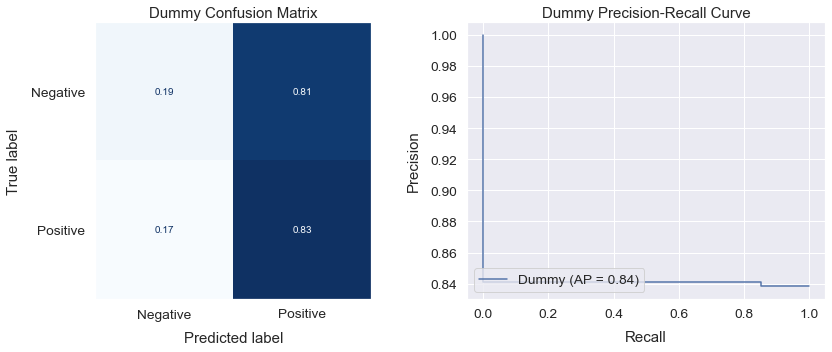

<IPython.core.display.Javascript object>

In [33]:
pipe.fit(X_train, y_train)
dummy_rep, dummy_cm, dummy_prc = eval_model(pipe, "Dummy")

It looks as bad as it should, with predictions as imbalanced as the classes. The precision-recall curve, if it can be called a "curve," is especially bad.

## Baseline Model: Random Forest

I begin by training a `BalancedRandomForestClassifier` from the [Imbalanced-Learn](https://imbalanced-learn.org/stable/) toolkit. I've chosen this classifier as a baseline because of its unique potential to deal with the class imbalance. It's the standard random forest algorithm with a twist: when bootstrapping datasets for each decision tree, it uses **random undersampling** instead of standard random sampling. This means that it balances the classes for each subsample by drawing fewer samples from the majority class.

The weakness of undersampling is that it potentially throws away a large amount of data from the majority class. However, since undersampling is performed for each tree in the forest, observations from the majority class have multiple chances to be selected and taken into consideration.

In [34]:
pipe.set_params(cls=BalancedRandomForestClassifier(random_state=53))

Pipeline(memory='pipe_cache',
         steps=[('vec', FreqVectorizer()),
                ('cls', BalancedRandomForestClassifier(random_state=53))],
         verbose=True)

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.8s


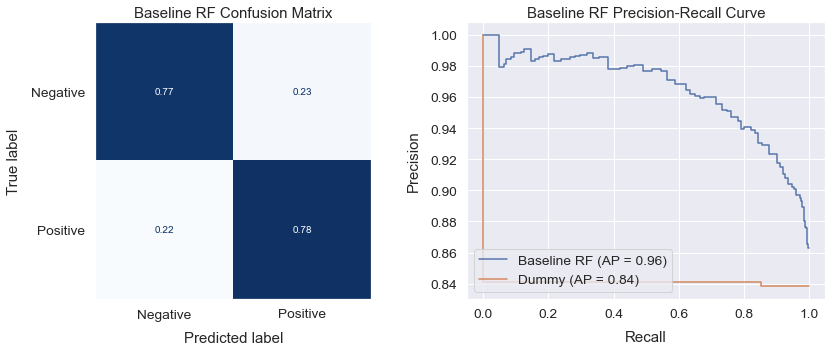

<IPython.core.display.Javascript object>

In [35]:
pipe.fit(X_train, y_train)
base_rep, base_cm, base_prc = eval_model(
    pipe, "Baseline RF", compare_curves=[dummy_prc]
)

Not bad for a baseline! Note that the confusion matrix has a strong diagonal with strong negative recall in particular. It couldn't contrast more with the dummy model's confusion matrix. Accordingly, it also has much higher macro-average recall than the dummy, and a healthy precision-recall curve.

## Adding `VaderVectorizer`

Next, I create a `FeatureUnion` which concatenates the output of `FreqVectorizer` with that of my custom `VaderVectorizer`.

`VaderVectorizer` extracts VADER (Valence Aware Dictionary and Sentiment Reasoner) polarity scores from documents and turns them into short vectors of shape (n_samples, 4). It's essentially a wrapper around the VADER tools found in NLTK. VADER analysis produces 4 scores: positive, neutral, negative, and compound. These are the 4 features in the matrix output by the vectorizer.

In [36]:
fu = FeatureUnion(
    [
        ("frq", FreqVectorizer()),
        ("vad", VaderVectorizer()),
    ],
    verbose=True,
)

pipe.set_params(vec=fu)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq', FreqVectorizer()),
                                                ('vad', VaderVectorizer())],
                              verbose=True)),
                ('cls', BalancedRandomForestClassifier(random_state=53))],
         verbose=True)

<IPython.core.display.Javascript object>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.7s


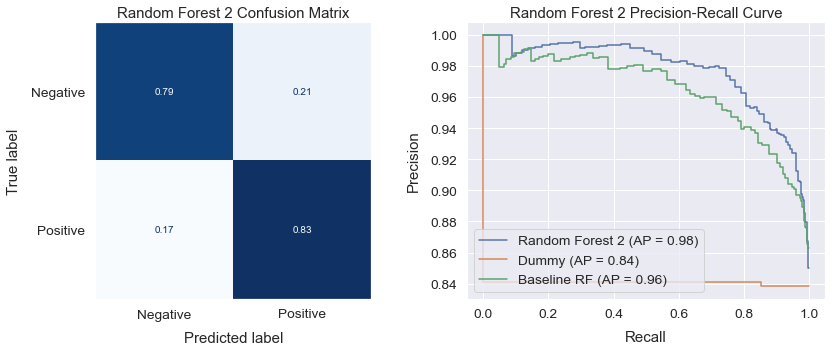

<IPython.core.display.Javascript object>

In [37]:
pipe.fit(X_train, y_train)
rf_rep, rf_cm, rf_prc = eval_model(
    pipe,
    "Random Forest 2",
    compare_curves=[dummy_prc, base_prc],
)

The macro-average recall is notably higher and the precision-recall curve is significantly wider than the baseline. As expected, the addition of `VaderVectorizer` is a major improvement.


## Selecting the Best Classifier

I started with `BalancedRandomForestClassifier` because I intuitively thought it would perform well, and it has. Nevertheless, I want to run a broad search over the hyperparameter space of multiple different classifiers. I will also try random undersampling and random oversampling with each of them.

The first step is to extend the pipeline to contain a resampler slot.

In [38]:
pipe = Pipeline(
    [
        ("vec", fu),
        ("res", "passthrough"),
        ("cls", BalancedRandomForestClassifier()),
    ],
    memory="pipe_cache",
    verbose=True,
)
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq', FreqVectorizer()),
                                                ('vad', VaderVectorizer())],
                              verbose=True)),
                ('res', 'passthrough'),
                ('cls', BalancedRandomForestClassifier())],
         verbose=True)

<IPython.core.display.Javascript object>

I'll also include the basic `FreqVectorizer` options in the search space. This will determine whether the vectors are binary occurrence, count, TF\*IDF, binary\*IDF, or some other variant.

In [39]:
tfidf_grid = {
    "vec__frq__binary": [True, False],
    "vec__frq__norm": ["l2", None],
    "vec__frq__smooth_idf": [True, False],
    "vec__frq__sublinear_tf": [True, False],
    "vec__frq__use_idf": [True, False],
}
tfidf_grid

{'vec__frq__binary': [True, False],
 'vec__frq__norm': ['l2', None],
 'vec__frq__smooth_idf': [True, False],
 'vec__frq__sublinear_tf': [True, False],
 'vec__frq__use_idf': [True, False]}

<IPython.core.display.Javascript object>

Next, I lay out the parameter space for four types of classifiers: random forest, logistic regression, support-vector machine, and naive bayes.

#### Notes on the Parameter Space

Due to the negative range of VADER's 'Compound' score, `VaderVectorizer` must be turned off for the naive bayes classifiers. Since `VaderVectorizer` has the option of rounding scores to the nearest integer, I'll include that as an option for the other classifiers.

I only try `RandomUnderSampler` and `RandomOverSampler` for now. If one of these finds its way into the best pipeline, I'll try out more sophisticated methods like `SMOTE`.

I opt to use 'liblinear' as the solver for `LogisticRegression` because it works well on small datasets and offers both L1 and L2 regularization.

In [40]:
classif_grid = [
    {
        "cls": [BalancedRandomForestClassifier()],
        "cls__n_estimators": sp.stats.randint(100, 1000),
        "cls__criterion": ["gini", "entropy"],
        "cls__max_depth": sp.stats.randint(10, 2000),
        "cls__min_samples_split": sp.stats.uniform(),
        "cls__min_samples_leaf": sp.stats.loguniform(1e-4, 0.25),
        "cls__replacement": [True, False],
        "res": ["passthrough"],
        "vec__vad__round_scores": [True, False],
        **tfidf_grid,
    },
    {
        "cls": [LogisticRegression(solver="liblinear")],
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        "cls__penalty": ["l1", "l2"],
        "cls__fit_intercept": [True, False],
        "cls__class_weight": ["balanced", None],
        "res": [RandomUnderSampler(), RandomOverSampler(), "passthrough"],
        "vec__vad__round_scores": [True, False],
        **tfidf_grid,
    },
    {
        "cls": [SVC()],
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        "cls__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "cls__shrinking": [True, False],
        "cls__break_ties": [True, False],
        "cls__class_weight": ["balanced", None],
        "res": [RandomOverSampler(), RandomUnderSampler(), "passthrough"],
        "vec__vad__round_scores": [True, False],
        **tfidf_grid,
    },
    {
        "cls": [ComplementNB(), MultinomialNB(), BernoulliNB()],
        "cls__alpha": sp.stats.loguniform(1e-4, 1e4),
        "res": [RandomOverSampler(), RandomUnderSampler(), "passthrough"],
        "vec__vad": ["drop"],
        **tfidf_grid,
    },
]
classif_grid

[{'cls': [BalancedRandomForestClassifier()],
  'cls__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x2c662222d00>,
  'cls__criterion': ['gini', 'entropy'],
  'cls__max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x2c662222f10>,
  'cls__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x2c662225070>,
  'cls__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x2c6622253a0>,
  'cls__replacement': [True, False],
  'res': ['passthrough'],
  'vec__vad__round_scores': [True, False],
  'vec__frq__binary': [True, False],
  'vec__frq__norm': ['l2', None],
  'vec__frq__smooth_idf': [True, False],
  'vec__frq__sublinear_tf': [True, False],
  'vec__frq__use_idf': [True, False]},
 {'cls': [LogisticRegression(solver='liblinear')],
  'cls__C': <scipy.stats._distn_infrastructure.rv_frozen at 0x2c662225610>,
  'cls__penalty': ['l1', 'l2'],
  'cls__fit_intercept': [True, False],
  'cls__class_weight': ['balanced', None],
  'res': [RandomUnd

<IPython.core.display.Javascript object>

Next I run the search using Scikit-Learn's `RandomizedSearchCV`. My `selection.sweep` function is a wrapper around all of the Scikit-Learn search estimators which allows for easily switching between them and saving the results. Here I've specified `kind='rand'` to fit a `RandomizedSearchCV` with 10,000 candidates.

I typically prefer `RandomizedSearchCV` to `GridSearchCV` because I like to specify the number of candidates to try. Adding inconsequential hyperparameters to the parameter space has no effect on the number of candidates tried.

In [41]:
if RUN_SWEEPS:
    search = selection.sweep(
        pipe,
        classif_grid,
        n_jobs=-1,
        kind="rand",
        X=X_train,
        y=y_train,
        n_iter=10 ** 4,
        scoring="recall_macro",
        cv_dst="sweeps/classifier.joblib",
    )
    classifier_results = search.cv_results_
else:
    classifier_results = joblib.load("sweeps/classifier.joblib")

classifier_results = selection.prune_cv(classifier_results)

<IPython.core.display.Javascript object>

In [42]:
classifier_results.head(10)

param_cls            C  alpha break_ties class_weight criterion  \
0     SVC()   108.387623    NaN       True         None       NaN   
1     SVC()    19.703076    NaN       True     balanced       NaN   
2     SVC()    75.553489    NaN      False         None       NaN   
3     SVC()     3.595819    NaN       True     balanced       NaN   
4     SVC()     3.370624    NaN      False     balanced       NaN   
5     SVC()   118.422907    NaN       True         None       NaN   
6     SVC()   624.686785    NaN      False     balanced       NaN   
7     SVC()  3101.865661    NaN      False     balanced       NaN   
8     SVC()  8454.321014    NaN      False         None       NaN   
9     SVC()   102.164007    NaN       True     balanced       NaN   

  fit_intercept kernel  max_depth  min_samples_leaf  ...  norm  smooth_idf  \
0           NaN    rbf        NaN               NaN  ...    l2        True   
1           NaN    rbf        NaN               NaN  ...    l2        True   
2           NaN   poly        NaN               NaN  ...    l2        True   
3           NaN   poly        NaN               NaN  ...    l2       False   
4           NaN    rbf        NaN               NaN  ...    l2       False   
5           NaN   poly        NaN               NaN  ...    l2        True   
6           NaN   poly        NaN               NaN  ...    l2       False   
7           NaN   poly        NaN               NaN  ...    l2       False   
8           NaN   poly        NaN               NaN  ...    l2        True   
9           NaN   poly        NaN               NaN  ...    l2        True   

  sublinear_tf use_idf  vad round_scores  \
0         True    True  NaN        False   
1         True    True  NaN        False   
2         True    True  NaN        False   
3        False   False  NaN        False   
4        False    True  NaN         True   
5         True   False  NaN        False   
6        False   False  NaN        False   
7        False   False  NaN        False   
8        False   False  NaN        False   
9         True    True  NaN        False   

                                              params mean_fit_time  \
0  {'cls': SVC(), 'cls__C': 108.3876234609627, 'c...      0.330799   
1  {'cls': SVC(), 'cls__C': 19.703075707568555, '...      0.337223   
2  {'cls': SVC(), 'cls__C': 75.55348904699694, 'c...      0.286599   
3  {'cls': SVC(), 'cls__C': 3.595818511081092, 'c...      0.323740   
4  {'cls': SVC(), 'cls__C': 3.370623837810783, 'c...      0.324798   
5  {'cls': SVC(), 'cls__C': 118.42290693610798, '...      0.310527   
6  {'cls': SVC(), 'cls__C': 624.6867851737038, 'c...      0.317598   
7  {'cls': SVC(), 'cls__C': 3101.865660946222, 'c...      0.328406   
8  {'cls': SVC(), 'cls__C': 8454.321013802326, 'c...      0.343416   
9  {'cls': SVC(), 'cls__C': 102.16400718875725, '...      0.362909   

   mean_score  rank_score  
0    0.782379           1  
1    0.781011           2  
2    0.780357           3  
3    0.779486           4  
4    0.778957           5  
5    0.778491           6  
6    0.778491           6  
7    0.778491           6  
8    0.778491           6  
9    0.777823          10  

[10 rows x 27 columns]

<IPython.core.display.Javascript object>

## Fitting an SVM

In [43]:
pipe.set_params(**classifier_results.loc[1, "params"], cls__probability=True)

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq',
                                                 FreqVectorizer(binary=True,
                                                                norm='l2',
                                                                sublinear_tf=True,
                                                                use_idf=True)),
                                                ('vad', VaderVectorizer())],
                              verbose=True)),
                ('res', RandomUnderSampler()),
                ('cls',
                 SVC(C=19.703075707568555, break_ties=True,
                     class_weight='balanced', probability=True))],
         verbose=True)

<IPython.core.display.Javascript object>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 3 of 3) Processing cls, total=   0.5s


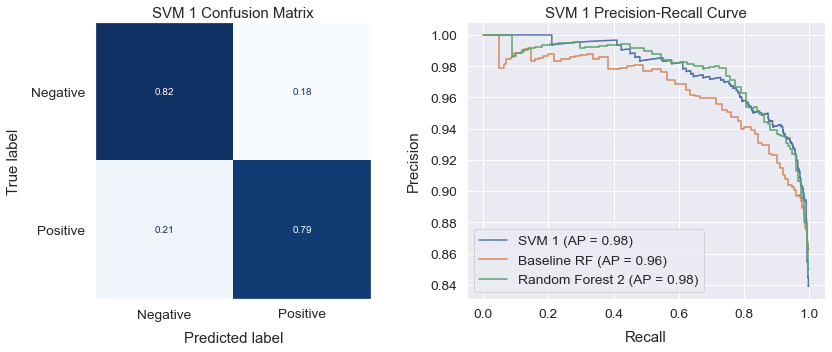

<IPython.core.display.Javascript object>

In [44]:
pipe.fit(X_train, y_train)
svm1_rep, svm1_cm, svm1_prc = eval_model(
    pipe, "SVM 1", compare_curves=[base_prc, rf_prc]
)

It's pretty similar to Random Forest 2. The biggest change seems to be the high negative recall. It also has a marginally wider precision-recall curve.

## Tuning the Preprocessing

First I define some stopwords for this particular dataset which I'd like to try out.

In [45]:
my_stop = {
    "america",
    "austin",
    "link",
    "mention",
    "southbysouthwest",
    "sxsw",
    "sxswi",
    "tweet",
    "twitter",
}

my_stop

{'america',
 'austin',
 'link',
 'mention',
 'southbysouthwest',
 'sxsw',
 'sxswi',
 'tweet',
 'twitter'}

<IPython.core.display.Javascript object>

Next I lay out the preprocessing hyperparameter space for `FreqVectorizer`. My `FreqVectorizer` has built-in lemmatization with NLTK's `WordnetLemmatizer`, as well as the ability to mark words between a negation term and sentence punctuation. I'll try both of these options as well as others which I've added to Scikit-Learn's `TfidfVectorizer`.

In [46]:
preproc_grid = {
    "vec__frq__stop_words": [my_stop, "nltk_english", None],
    "vec__frq__tokenizer": [
        nltk.word_tokenize,
        nltk.casual_tokenize,
        nltk.wordpunct_tokenize,
        None,
    ],
    "vec__frq__ngram_range": [(1, 1), (1, 2)],
    "vec__frq__max_df": sp.stats.uniform(0.05, 0.95),
    "vec__frq__strip_numeric": [True, False],
    "vec__frq__strip_twitter_handles": [True, False],
    "vec__frq__limit_repeats": [True, False],
    "vec__frq__mark_negation": [True, False],
    "vec__frq__stemmer": ["wordnet", None],
}
preproc_grid

{'vec__frq__stop_words': [{'america',
   'austin',
   'link',
   'mention',
   'southbysouthwest',
   'sxsw',
   'sxswi',
   'tweet',
   'twitter'},
  'nltk_english',
  None],
 'vec__frq__tokenizer': [<function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>,
  <function nltk.tokenize.casual.casual_tokenize(text, preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True)>,
  <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>,
  None],
 'vec__frq__ngram_range': [(1, 1), (1, 2)],
 'vec__frq__max_df': <scipy.stats._distn_infrastructure.rv_frozen at 0x2c66225eac0>,
 'vec__frq__strip_numeric': [True, False],
 'vec__frq__strip_twitter_handles': [True, False],
 'vec__frq__limit_repeats': [True, False],
 'vec__frq__mark_negation': [True, False],
 'vec__frq__stemmer': ['wordnet', None]}

<IPython.core.display.Javascript object>

Next I run a randomized search over `preproc_grid` with 1000 candidates. That should be enough to optimize the preprocessing.

In [47]:
if RUN_SWEEPS:
    search = selection.sweep(
        pipe,
        preproc_grid,
        n_jobs=-1,
        kind="rand",
        X=X_train,
        y=y_train,
        n_iter=1000,
        scoring="recall_macro",
        cv_dst="sweeps/preproc.joblib",
    )
    preproc_results = search.cv_results_
else:
    preproc_results = joblib.load("sweeps/preproc.joblib")

preproc_results = selection.prune_cv(preproc_results)

<IPython.core.display.Javascript object>

In [48]:
preproc_results.head(10)

limit_repeats  mark_negation    max_df ngram_range  stemmer  \
0           True           True  0.452590      (1, 1)     None   
1           True           True  0.977528      (1, 1)  wordnet   
2           True           True  0.811677      (1, 1)  wordnet   
3           True           True  0.773526      (1, 1)  wordnet   
4          False           True  0.249638      (1, 1)  wordnet   
5           True           True  0.126879      (1, 1)  wordnet   
6           True           True  0.315786      (1, 1)  wordnet   
7          False           True  0.526762      (1, 1)  wordnet   
8           True           True  0.945616      (1, 1)     None   
9          False           True  0.758515      (1, 1)     None   

                                          stop_words  strip_numeric  \
0                                       nltk_english          False   
1  {sxsw, twitter, link, america, southbysouthwes...           True   
2  {sxsw, twitter, link, america, southbysouthwes...          False   
3  {sxsw, twitter, link, america, southbysouthwes...          False   
4  {sxsw, twitter, link, america, southbysouthwes...          False   
5  {sxsw, twitter, link, america, southbysouthwes...          False   
6                                               None          False   
7                                               None          False   
8                                       nltk_english           True   
9  {sxsw, twitter, link, america, southbysouthwes...          False   

   strip_twitter_handles                                          tokenizer  \
0                  False     <function word_tokenize at 0x000002C6515CC8B0>   
1                  False     <function word_tokenize at 0x000002C6515CC8B0>   
2                   True     <function word_tokenize at 0x000002C6515CC8B0>   
3                   True     <function word_tokenize at 0x000002C6515CC8B0>   
4                  False     <function word_tokenize at 0x000002C6515CC8B0>   
5                   True  <bound method RegexpTokenizer.tokenize of Word...   
6                  False   <function casual_tokenize at 0x000002C65058B940>   
7                  False   <function casual_tokenize at 0x000002C65058B940>   
8                   True     <function word_tokenize at 0x000002C6515CC8B0>   
9                   True   <function casual_tokenize at 0x000002C65058B940>   

                                              params  mean_fit_time  \
0  {'vec__frq__limit_repeats': True, 'vec__frq__m...       3.326375   
1  {'vec__frq__limit_repeats': True, 'vec__frq__m...       9.399600   
2  {'vec__frq__limit_repeats': True, 'vec__frq__m...       9.205640   
3  {'vec__frq__limit_repeats': True, 'vec__frq__m...       9.219135   
4  {'vec__frq__limit_repeats': False, 'vec__frq__...       8.764399   
5  {'vec__frq__limit_repeats': True, 'vec__frq__m...       8.180685   
6  {'vec__frq__limit_repeats': True, 'vec__frq__m...       8.840783   
7  {'vec__frq__limit_repeats': False, 'vec__frq__...       8.368999   
8  {'vec__frq__limit_repeats': True, 'vec__frq__m...       3.332243   
9  {'vec__frq__limit_repeats': False, 'vec__frq__...       2.919505   

   mean_score  rank_score  
0    0.802835           1  
1    0.799584           2  
2    0.798919           3  
3    0.798919           3  
4    0.798651           5  
5    0.798255           6  
6    0.796869           7  
7    0.795950           8  
8    0.795445           9  
9    0.795048          10

<IPython.core.display.Javascript object>

Looks like `mark_negation=True` won out pretty robustly, which doesn't surprise me. `nltk.word_tokenize` is also a clear winner, as is `ngram_range=(1, 1)`.

## Fitting a Second SVM

Next I set the best parameters and fit another model. I'm anticipating some improvement.

In [49]:
pipe.set_params(**preproc_results.loc[0, "params"])

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq',
                                                 FreqVectorizer(binary=True,
                                                                limit_repeats=True,
                                                                mark_negation=True,
                                                                max_df=0.4525897144046643,
                                                                norm='l2',
                                                                stop_words='nltk_english',
                                                                sublinear_tf=True,
                                                                tokenizer=<function word_tokenize at 0x000002C6515CC8B0>,
                                                                use_idf=True)),
                                                ('vad', VaderVectorizer())],
                          

<IPython.core.display.Javascript object>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 3 of 3) Processing cls, total=   0.4s


C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


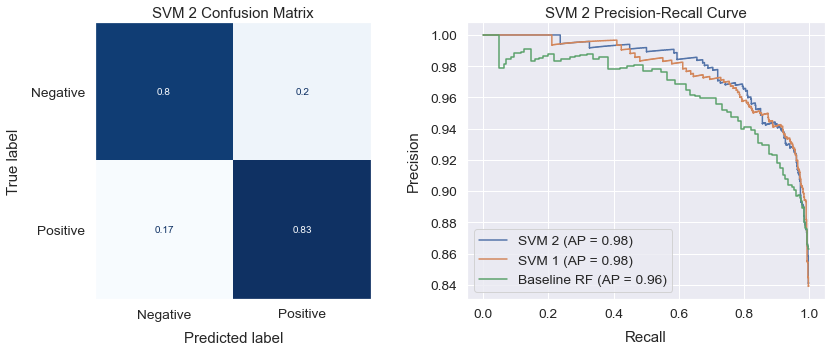

<IPython.core.display.Javascript object>

In [50]:
pipe.fit(X_train, y_train)
svm2_rep, svm2_cm, svm2_prc = eval_model(
    pipe, "SVM 2", compare_curves=[svm1_prc, base_prc]
)

There's a significant increase in macro recall, and the precision-recall curve is slightly wider than that of SVM 1.

It doesn't seem like I'm going to be able to improve much over this model, at least by conventional means. One possibility would be to use a `StackingClassifier` to combine the results of multiple different classifiers. Rather than go down that rabbit hole, I think I'll try fine-tuning a pre-trained neural network. The latter seems more promising, especially given the small size of the dataset. A pre-trained network will bring additional information with it, in a sense.

I go ahead and refit the final conventional model on the full `X` and save it.

In [51]:
pipe.fit(X, y)
joblib.dump(pipe, "models/final_svm.joblib", compress=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 3 of 3) Processing cls, total=   0.8s


['models/final_svm.joblib']

<IPython.core.display.Javascript object>

## Fine-Tuning a BERT

I'm going to try using transfer learning to improve upon my previous model, and in particular, I'm going to fine-tune a pre-trained BERT model. BERT (Bidirectional Encoder Representations from Transformers) is a state of the art language understanding model trained on the union of the Toronto Book Corpus and Wikipedia. It's "bidirectional" in the sense that it takes both left and right context into account during training. It can be fine-tuned for a specific task (such as the present task) using one additional layer of neurons.

Before training the model, I need to find out the maximum sequence length for my dataset. I
do this by tokenizing it with the BERT tokenizer and finding the maximum length.

In [52]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=False)
df["text"].map(bert_tokenizer.tokenize).str.len().max()

50

<IPython.core.display.Javascript object>

I use [this](https://github.com/charles9n/bert-sklearn) Scikit-Learn wrapper for the Huggingface Transformers port of Google's BERT. The underlying model is a PyTorch model.

I start with the default hyperparameters, except for a few which I set in advance. I arrive at the training batch size through a process of trial and error with my GPU.

In [53]:
bert = BertClassifier(
    do_lower_case=True,
    train_batch_size=28,
    max_seq_length=50,
)
bert.get_params()

Building sklearn text classifier...


{'bert_config_json': None,
 'bert_model': 'bert-base-uncased',
 'bert_vocab': None,
 'do_lower_case': True,
 'epochs': 3,
 'eval_batch_size': 8,
 'fp16': False,
 'from_tf': False,
 'gradient_accumulation_steps': 1,
 'ignore_label': None,
 'label_list': None,
 'learning_rate': 2e-05,
 'local_rank': -1,
 'logfile': 'bert_sklearn.log',
 'loss_scale': 0,
 'max_seq_length': 50,
 'num_mlp_hiddens': 500,
 'num_mlp_layers': 0,
 'random_state': 42,
 'restore_file': None,
 'train_batch_size': 28,
 'use_cuda': True,
 'validation_fraction': 0.1,
 'warmup_proportion': 0.1}

<IPython.core.display.Javascript object>

### Fitting a Baseline BERT

I fit the model with mostly default hyperparameters, then evaluate the result.

In [54]:
if FIT_BERT:
    bert.fit(X_train, y_train)
    bert.save("models/bert_baseline.bin")
else:
    bert = bert_sklearn.load_model("models/bert_baseline.bin")

bert

Loading model from models/bert_baseline.bin...
Defaulting to linear classifier/regressor
Building sklearn text classifier...


BertClassifier(bert_config_json={'architectures': ['BertForMaskedLM'],
                                 'attention_probs_dropout_prob': 0.1,
                                 'hidden_act': 'gelu',
                                 'hidden_dropout_prob': 0.1, 'hidden_size': 768,
                                 'initializer_range': 0.02,
                                 'intermediate_size': 3072,
                                 'layer_norm_eps': 1e-12,
                                 'max_position_embeddings': 512,
                                 'model_type': 'bert',
                                 'num_attention_heads': 12,
                                 'num_hidden_layers': 12, 'pad_token_...
                                       ('[unused15]', 16), ('[unused16]', 17),
                                       ('[unused17]', 18), ('[unused18]', 19),
                                       ('[unused19]', 20), ('[unused20]', 21),
                                       ('[unused21]', 2

<IPython.core.display.Javascript object>

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  8.58it/s]


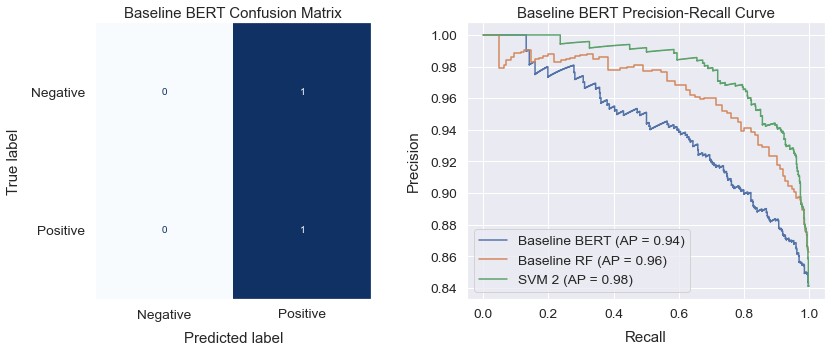

<IPython.core.display.Javascript object>

In [55]:
bert1_rep, bert1_cm, bert1_prc = eval_model(
    bert,
    "Baseline BERT",
    compare_curves=[base_prc, svm2_prc],
)

Looks terrible! It's worse than Baseline RF because it almost always predicts the positive class. Perhaps with some hand-tuning of the hyperparameters, this can be improved.

### Fitting a Second BERT

I hand-tune the hyperparameters until I'm able to create a high quality model.

In [56]:
bert.set_params(
    num_mlp_hiddens=750,
    num_mlp_layers=2,
    epochs=4,
)

BertClassifier(bert_config_json={'architectures': ['BertForMaskedLM'],
                                 'attention_probs_dropout_prob': 0.1,
                                 'hidden_act': 'gelu',
                                 'hidden_dropout_prob': 0.1, 'hidden_size': 768,
                                 'initializer_range': 0.02,
                                 'intermediate_size': 3072,
                                 'layer_norm_eps': 1e-12,
                                 'max_position_embeddings': 512,
                                 'model_type': 'bert',
                                 'num_attention_heads': 12,
                                 'num_hidden_layers': 12, 'pad_token_...
                                       ('[unused17]', 18), ('[unused18]', 19),
                                       ('[unused19]', 20), ('[unused20]', 21),
                                       ('[unused21]', 22), ('[unused22]', 23),
                                       ('[unused23]', 2

<IPython.core.display.Javascript object>

I find that using a multi-layer perceptron classifier with 2 hidden layers of 750 neurons each results in a much better model. I also set it to traverse the corpus 4 times.

In [57]:
if FIT_BERT:
    bert.fit(X_train, y_train)
    bert.save("models/bert_train.bin")
else:
    bert = bert_sklearn.load_model("models/bert_train.bin")

bert

Loading model from models/bert_train.bin...
Using mlp with D=768,H=750,K=2,n=2
Building sklearn text classifier...


BertClassifier(bert_config_json={'architectures': ['BertForMaskedLM'],
                                 'attention_probs_dropout_prob': 0.1,
                                 'hidden_act': 'gelu',
                                 'hidden_dropout_prob': 0.1, 'hidden_size': 768,
                                 'initializer_range': 0.02,
                                 'intermediate_size': 3072,
                                 'layer_norm_eps': 1e-12,
                                 'max_position_embeddings': 512,
                                 'model_type': 'bert',
                                 'num_attention_heads': 12,
                                 'num_hidden_layers': 12, 'pad_token_...
                                       ('[unused17]', 18), ('[unused18]', 19),
                                       ('[unused19]', 20), ('[unused20]', 21),
                                       ('[unused21]', 22), ('[unused22]', 23),
                                       ('[unused23]', 2

<IPython.core.display.Javascript object>

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  8.76it/s]


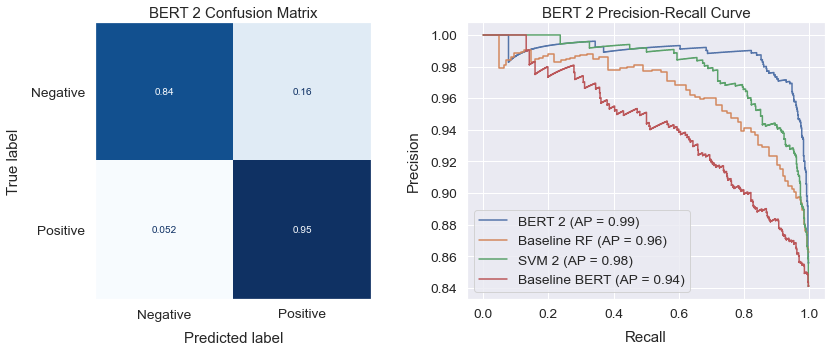

<IPython.core.display.Javascript object>

In [58]:
bert2_rep, bert2_cm, bert2_prc = eval_model(
    bert,
    "BERT 2",
    compare_curves=[base_prc, svm2_prc, bert1_prc],
)

It's a major improvement, with the highest macro recall I've seen yet. The precision-recall curve is much wider than the final conventional model, SVM 2, and the average precision is up to 0.99. The model's accuracy score is also a nice 0.95.

### Refitting the Final Model

I'm so impressed with this last BERT model that I'll consider it my final model. Now I simply need to refit using the full `X` and `y`.

In [59]:
if FIT_BERT:
    bert.fit(X, y)
    bert.save("models/bert_final.bin")
else:
    bert = bert_sklearn.load_model("models/bert_final.bin")

bert

Loading model from models/bert_final.bin...
Using mlp with D=768,H=750,K=2,n=2
Building sklearn text classifier...


BertClassifier(bert_config_json={'architectures': ['BertForMaskedLM'],
                                 'attention_probs_dropout_prob': 0.1,
                                 'hidden_act': 'gelu',
                                 'hidden_dropout_prob': 0.1, 'hidden_size': 768,
                                 'initializer_range': 0.02,
                                 'intermediate_size': 3072,
                                 'layer_norm_eps': 1e-12,
                                 'max_position_embeddings': 512,
                                 'model_type': 'bert',
                                 'num_attention_heads': 12,
                                 'num_hidden_layers': 12, 'pad_token_...
                                       ('[unused17]', 18), ('[unused18]', 19),
                                       ('[unused19]', 20), ('[unused20]', 21),
                                       ('[unused21]', 22), ('[unused22]', 23),
                                       ('[unused23]', 2

<IPython.core.display.Javascript object>

# Interpretation

Artificial neural networks are the most difficult type of model to interpret because they are comprised of interconnected layers of neurons, and the neurons have no meaning&mdash;they are just neurons. They are difficult to interpret and explain in much the same way that a biological brain would be. Perhaps experts can glean something from the activity inside a neural network in a controlled setting, but in typical practice, they are treated as black boxes.

There are many indirect approaches to explaining the output of a neural network. One approach is to create a global surrogate model by training a conventional machine learning model on the output of a neural network. Another approach is to create local surrogate models which approximate the neural network's behavior in the vicinity of a particular example. There are many other approaches as well.

#### Bigram Analysis

For my purposes, I am much more interested in what the model says about the data than in the model itself. I will take the simple approach of searching for bigrams in the text and predicting probabilities for them.

In [60]:
# Add some hashtags to stopwords
my_stop |= {"#sxsw", "#sxswi", "#austin", "#america"}
ngrams = lang.scored_bigrams(
    df["text"],
    stopwords=my_stop | lang.fetch_stopwords("nltk_english | sklearn_english"),
    tokenizer=partial(nltk.casual_tokenize, preserve_case=False, strip_handles=True),
    min_freq=5,
    metric="pmi",
)

ngrams = ngrams.loc[lambda x: x > x.quantile(0.75)].copy()
ngrams.index = ngrams.index.str.join(" ")
ngrams

bigram
ice cream               13.143096
interrupt regularly     13.143096
league extraordinary    12.880062
lustre pearl            12.880062
speech therapy          12.880062
                          ...    
2 takes                  5.687769
long line                5.680389
new version              5.676397
/ bing                   5.665743
drivers 2                5.635302
Name: score, Length: 229, dtype: float64

<IPython.core.display.Javascript object>

In [61]:
ngram_proba = pd.DataFrame(
    bert.predict_proba(ngrams.index.to_list()),
    columns=["neg", "pos"],
    index=ngrams.index,
)
ngram_proba

Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


neg       pos
bigram                                  
ice cream             0.262451  0.737549
interrupt regularly   0.263221  0.736779
league extraordinary  0.095287  0.904713
lustre pearl          0.558731  0.441269
speech therapy        0.454237  0.545763
...                        ...       ...
2 takes               0.618104  0.381896
long line             0.306551  0.693449
new version           0.840470  0.159530
/ bing                0.637566  0.362434
drivers 2             0.664487  0.335513

[229 rows x 2 columns]

<IPython.core.display.Javascript object>

Before moving on, I define a function for displaying a readable sample of tweets containing a certain regex pattern. There is an option to specify a particular brand.

In [62]:
def read_tweets(
    pattern,
    data=df,
    brand=None,
    text_col="text",
    brand_col="object_of_emotion",
    case=False,
    max_sample=10,
    random_state=578,
):
    """Show a readable sample of tweets containing a match for `pattern`."""
    if brand is None:
        text = data[text_col].copy()
    else:
        text = data.loc[data[brand_col] == brand, text_col].copy()
    contains_pat = text.loc[lambda x: x.str.contains(pattern, case=case)]
    return lang.readable_sample(contains_pat, n=max_sample, random_state=random_state)

<IPython.core.display.Javascript object>

## Top Bigrams for the Positive Class
I make a wordcloud below using the positive class probabilities.

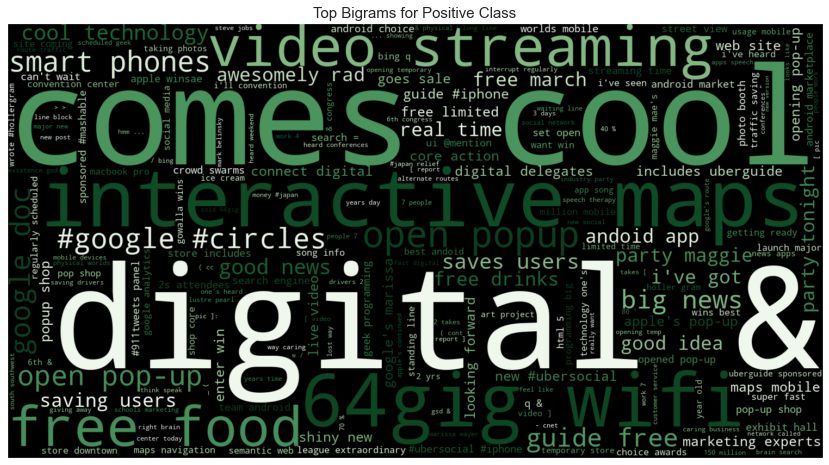

<IPython.core.display.Javascript object>

In [102]:
ax = plotting.wordcloud(
    ngram_proba["pos"],
    cmap="Greens",
    size=(15, 8),
    desat=0.7,
    random_state=35,
)
ax.set(title="Top Bigrams for Positive Class")
ax.figure.savefig("images/positive_bigram_proba.svg", bbox_inches="tight")

I notice phrases like "free food" and "free drinks", which I don't think I've seen before. Some of the other phrases are familiar from `exploratory.ipynb`, such as "shiny new" and "cool technology". There is also positive talk about Apple's pop-up shop.

In [64]:
read_tweets("free drinks|free food")

|      | text                                                                                                                                                   |
|-----:|:-------------------------------------------------------------------------------------------------------------------------------------------------------|
|  482 | Badgeless event! Free Drinks! UI@mention Heading to free Google-sponsored happy hour for Semantic Web Austin @mention Fogo de ChIAo #sxswU             |
| 5851 | RT @mention Google Party is at GSD&M (Google Map it). #SXSW badge gets u in. Free food, drinks, music. Big place. No line. Great party. Come!          |
| 7181 | Come! "@mention Google Party is at GSD&M #SXSW badge gets u in. Free food, drinks, music. Big place. No line. Great party. Come!"                      |
| 7796 | Google party, don't think they are checking for badges if you say your on list. Free food and booze. #frood #sxsw CC @mention                          |
| 2846 | Free coffee by company a, free drinks on company b, free food at company c. All money saved goes to Apple. Life at #SXSW. ;)                           |
| 5542 | RT @mention Badgeless event! Free Drinks! UI@mention Heading to free Google-sponsored happy hour for Semantic Web Austin @mention Fogo de ChIAo #sxswU |
| 2097 | I go to bars and get free drinks because I have an iPhone. #doesdroid #SXSW                                                                            |
| 7795 | Google Party is at GSD&M (Google Map it). #SXSW badge gets u in. Free food, drinks, music. Big place. No line. Great party. Come!                      |
| 7550 | Thanks for the free drinks Google! #sxsw (@mention Speakeasy w/ 47 others) {link}                                                                      |

<IPython.core.display.Javascript object>

Looks like Google had a party with free food and drinks, and people really liked it.

I'll use LIME to examine one of these tweets. LIME is a tool which creates a local surrogate model to approximate a model's predictions around a particular example.

In [65]:
expl = LimeTextExplainer(
    class_names=["Negative", "Positive"],
    # I use nltk.casual_tokenize because BERT tokenizer raises errors
    split_expression=nltk.casual_tokenize,
    # Consider word order
    bow=False,
    # Mask string from BERT tokenizer
    mask_string="[MASK]",
)
expl_free_food = expl.explain_instance(df.at[7796, "text"].lower(), bert.predict_proba)
expl_free_food.show_in_notebook()

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.39it/s]


<IPython.core.display.Javascript object>

It looks like the word "free" is especially associated with the positive class. That's hardly surprising. LIME doesn't seem to provide much additional insight for my purposes. Anyway, I'll definitely recommend that Apple give away free food and drinks, as Google did at this party.

In [66]:
read_tweets("64gig wifi")

|      | text                                                                                                                          |
|-----:|:------------------------------------------------------------------------------------------------------------------------------|
| 2596 | Only white #ipad2 64gig wifi available at #Austin #SXSW #Apple popup store right now, but no wait!                            |
|  149 | UI@mention #sxsw ipad store sold out of everything except 64gig wifi only whiteU @mention Did you manage to get yours?        |
| 4031 | now I feel better (#106 1st day) @mention #sxsw ipad store sold out of everything except 64gig wifi only white                |
| 1530 | @mention (via @mention #sxsw ipad store sold out of everything except 64gig wifi only white                                   |
|  150 | UI@mention #sxsw ipad store sold out of everything except 64gig wifi only whiteU also known as the white jeans configuration. |
| 5303 | RT @mention #sxsw ipad store sold out of everything except 64gig wifi only white                                              |

<IPython.core.display.Javascript object>

Looks like Apple sold out of every iPad 2 except the white 64gb model with wifi only (i.e. no mobile service). This is good news for Apple.

## Top Bigrams for the Negative Class

Next, I plot the top bigrams for the negative class.

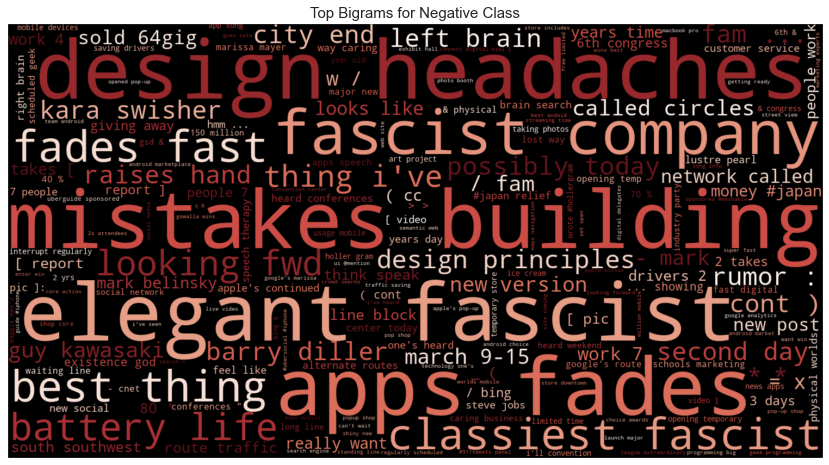

<IPython.core.display.Javascript object>

In [104]:
ax = plotting.wordcloud(
    ngram_proba["neg"],
    cmap="Reds",
    size=(15, 8),
    desat=0.7,
    random_state=5,
)
ax.set(title="Top Bigrams for Negative Class")
ax.figure.savefig("images/negative_bigram_proba.svg", bbox_inches="tight")

As in the EDA notebook, we see that people were talking about Apple being a "fascist company". This began with tech journalist [Kara Swisher](https://en.wikipedia.org/wiki/Kara_Swisher), who provoked a flurry of tweets by saying that Apple was the "classiest fascist company in America".

Again phrases show up related to sending iPad 2 money to Japan instead of spending it on an iPad. This is in response to the [Fukushima Daiichi nuclear disaster](https://en.wikipedia.org/wiki/Fukushima_Daiichi_nuclear_disaster).

Negative talk about the iPhone's battery life shows up again, as does talk about Josh Clark's presentation on iPad Design Headaches. There also is some negativity associated with Apple selling out of everything but 64gb iPads.

As in the EDA notebook, the phrase "fades fast" is related to talk about novelty iOS news apps having a short lifespan.

In [105]:
read_tweets("march 9-15")

|      | text                                                                                                                               |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------|
| 5786 | RT @mention Going to #SXSW? The new iPhone guide to #Austin by @mention is free March 9-15. Hard to beat free. #lp                 |
| 1205 | Excellent tip from @mention Going to #SXSW? The new iPhone guide to #Austin by @mention is free March 9-15. Hard to beat free. #lp |
| 5787 | RT @mention Going to #SXSW? The new iPhone guide to #Austin by @mention is free March 9-15. Hard to beat free. #lp #mobile         |
| 2010 | Lonely Planet's new iPhone Austin city guide is free March 9-15 for those going to #SXSW! {link} #travel                           |
| 1748 | Going to #SXSW? The new iPhone guide to #Austin by @mention is free March 9-15. Hard to beat free. #lp                             |

<IPython.core.display.Javascript object>

The phrase "march 9-15" is evidently related to a free iPhone app giveaway&mdash;Lonely Planet's city guide to Austin, TX. This doesn't seem like a big deal for Apple, although it's unclear why it's associated with the negative class.

In [106]:
expl_march_915 = expl.explain_instance("march 9-15", bert.predict_proba)
expl_march_915.show_in_notebook()

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:28<00:00, 22.15it/s]


<IPython.core.display.Javascript object>

Even after using LIME, it's still unclear why "march 9-15" is associated with the negative class. What is clear is that is has something to do with "9-15". Anyway, I'll move on to investigating "mistakes building."

In [107]:
read_tweets("mistakes made building")

|      | text                                                                                                         |
|-----:|:-------------------------------------------------------------------------------------------------------------|
| 2735 | Looks like this was a fun session at #SXSW: "Mistakes Made Building Nextflix for iPhone": {link}             |
| 8098 | #SXSW: Mistakes Made Building Netflix for iPhone (Plus, How to See Its Source Code!) {link} via @mention     |
| 8096 | #SXSW: Mistakes Made Building @mention for iPhone (Plus, How to See Its Source Code!) {link}                 |
| 6274 | RT @mention Looks like this was a fun session at #SXSW: "Mistakes Made Building Nextflix for iPhone": {link} |

<IPython.core.display.Javascript object>

The phrase "mistakes building" is related to a talk about mistakes made building the iPhone Netflix app. This seems relatively benign as far as Apple is concerned.

In [108]:
read_tweets("steve jobs")

|      | text                                                                                                                                      |
|-----:|:------------------------------------------------------------------------------------------------------------------------------------------|
| 6069 | RT @mention I wonder if Apple intentionally scheduled the #iPad2 release to coincide with #SXSW. Steve Jobs, you crafty genius, youU_     |
| 2341 | #sxsw #enchantment: @mention "Sell your dream. Steve Jobs doesn't say: iPhone is $188 of parts+AT&T, made by ppl in suicidal Chinese      |
| 7851 | Steve Jobs doesn't position the iPhone as a device made in China where suicide rates are high He sells dreams #Kawasaki #thisisdare #SXSW |
| 3617 | I wonder if Apple intentionally scheduled the #iPad2 release to coincide with #SXSW. Steve Jobs, you crafty genius, youU_                 |
| 2818 | Apple cited as the opposite of crowdsourcing - proprietary, Steve Jobs tells you what you want #csuitecsourcing #sxsw                     |

<IPython.core.display.Javascript object>

There seems to be sarcastic talk about Steve Jobs, who was CEO of Apple during SXSW, 2011. This was a period of transition between Jobs and Tim Cook, as Jobs was having health difficulties at the time. Steve Jobs resigned later that year, and passed away shortly afterward.

Some of the talk is about unethical manufacturing practices related to Chinese factories with poor working conditions and high suicide rates.

## Searching by Brand

Next, I extract the top 25% of bigrams for each brand (considered as an independent corpus).

In [109]:
# Find bigrams with brand-wise grouping
brand_ngrams = lang.stratified_ngrams(
    df,
    tokenizer=partial(nltk.casual_tokenize, preserve_case=False, strip_handles=True),
    text="text",
    stopwords=my_stop | lang.fetch_stopwords("nltk_english | sklearn_english"),
    cat="object_of_emotion",
    min_freq=3,
    select_best=0.25,
    metric="pmi",
)

# Drop duplicates and index by bigram
brand_ngrams = (
    brand_ngrams.sort_values("score", ascending=False)
    .drop_duplicates(subset=["bigram"])
    .set_index("bigram")
)

# Join tuples with space
brand_ngrams.index = brand_ngrams.index.str.join(" ")
brand_ngrams

score    object_of_emotion
bigram                                             
shameless promotion  12.063283                 iPad
tests muro           12.063283                 iPad
resulting shameless  12.063283                 iPad
muro drawing         12.063283                 iPad
deviantart buys      12.063283                 iPad
...                        ...                  ...
sampler itunes        4.877744  Other Apple Product
awards .              4.460826          Android App
new #android          4.360063          Android App
+ android             3.951609              Android
android tablet        3.951609              Android

[470 rows x 2 columns]

<IPython.core.display.Javascript object>

I define a function below for plotting positive and negative wordclouds for a particular brand. It's similar to the one I use in the EDA notebook.

In [110]:
def plot_brand_clouds(
    brand,
    model=bert,
    brand_ngrams=brand_ngrams,
    dst_schema="images/{brand}_bigram_proba.svg",
    cmap=("Reds", "Greens"),
    size=(10, 4),
    ncols=1,
    max_font_size=None,
    random_state=156,
    **kwargs,
):
    """Predict probabilities and plot positive and negative wordclouds."""
    scored_ngrams = brand_ngrams.loc[
        lambda x: x.object_of_emotion == brand, "score"
    ].copy()

    columns = [f"{brand}: Negative", f"{brand}: Positive"]
    ngram_proba = pd.DataFrame(
        model.predict_proba(scored_ngrams.index.to_list()),
        columns=columns,
        index=scored_ngrams.index,
    )

    fig = plotting.wordcloud(
        ngram_proba,
        cmap=list(cmap),
        size=size,
        ncols=ncols,
        repeat=True,
        max_font_size=max_font_size,
        random_state=random_state,
        **kwargs,
    )
    fig.savefig(dst_schema.format(brand=brand.lower().replace(" ", "_")))
    return fig

<IPython.core.display.Javascript object>

### Top Apple Bigrams

Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.12it/s]


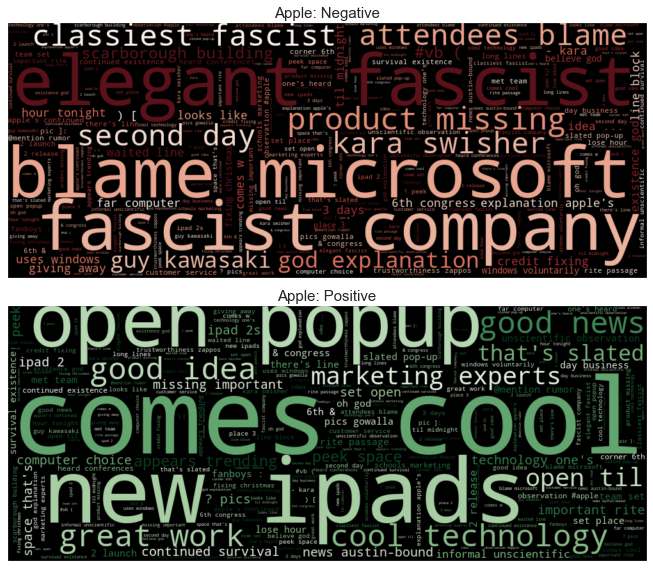

<IPython.core.display.Javascript object>

In [111]:
fig = plot_brand_clouds("Apple")

Phrases like "fascist company"  and "kara swisher" show up again, as expected. There's positive talk about the new iPads and the popup store selling them, which is also expected. What's this "blame microsoft" thing, I wonder?

In [112]:
read_tweets("blame microsoft", brand="Apple")

|      | text                                                                                                                                         |
|-----:|:---------------------------------------------------------------------------------------------------------------------------------------------|
| 4426 | We lose an hour tonight. #SxSW attendees will blame Microsoft, Apple will get credit for fixing it before Christmas.                         |
| 6888 | RT @mention We lose hour 2nite. #SxSW attendees will blame Microsoft, Apple will get credit 4 fixing it b4 Christmas.                        |
| 6887 | RT @mention We lose an hour tonight. #SxSW attendees will blame Microsoft, Apple will get credit for fixing it before Christmas.             |
| 6621 | RT @mention RT @mention We lose an hour tonight. #SxSW attendees will blame Microsoft, Apple will get credit for fixing it before Christmas. |

<IPython.core.display.Javascript object>

This appears to be a joke about daylight savings time. The suggestion is that Microsoft gets undeserved blame at SXSW, and Apple gets undeserved praise.

In [113]:
read_tweets("product you're missing", brand="Apple")

|      | text                                                                                                                                  |
|-----:|:--------------------------------------------------------------------------------------------------------------------------------------|
| 8770 | If you haven't waited in line for an Apple product you're missing out on an important rite of passage. #sxsw                          |
| 1598 | Haha! RT @mention If you haven't waited in line for an Apple product you're missing out on an important rite of passage. #sxsw        |
| 8739 | geeking out? RT @mention If you haven't waited in line for an Apple product you're missing out on an important rite of passage. #sxsw |

<IPython.core.display.Javascript object>

The phrase "product missing" should actually be "product you're missing," and the tweets containing it are positive.

In [114]:
read_tweets("marketing experts", brand="Apple")

|      | text                                                                                                                                |
|-----:|:------------------------------------------------------------------------------------------------------------------------------------|
| 5171 | RT @mention "At #SXSW, Apple schools the marketing experts" {link}                                                                  |
|  283 | At #SXSW, Apple schools the marketing experts {link}                                                                                |
| 2046 | At SXSW, Apple schools the marketing experts {link} #SXSW                                                                           |
| 2047 | At SXSW, Apple schools the marketing experts {link} /via @mention #SXSW #Apple                                                      |
| 1737 | #tech At #SXSW, Apple schools the marketing experts {link}                                                                          |
| 1736 | "At #SXSW, Apple schools the marketing experts" {link}                                                                              |
| 7694 | Social marketing experts at #SXSW: Everyone has to face facts & admit that Apple again showed everyone how marketing is done. #CNET |
| 8162 | "At SXSW, Apple schools the marketing experts" {link} #sxsw                                                                         |
|  116 | At #SXSW, #Apple schools the marketing experts - {link}                                                                             |
| 5524 | RT @mention At SXSW, Apple schools the marketing experts: {link} via @mention #sxsw #apple #marketing                               |

<IPython.core.display.Javascript object>

The phrase "marketing experts" is related to tweets praising Apple's marketing strategies. That's definitely good to see.

In [115]:
read_tweets("god", brand="Apple")

|      | text                                                                                                                                                |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------------------|
| 5271 | RT @mention #sxsw #enchantment: @mention "Bright spot for Apple: Pagemaker saved Apple. I believe in God b/c no other explanation of Apple survival |
|  109 | Kawasaki: "Not C.S. Lewis level reasoning, but Apple's continued existence is evidence for the existence of God" #bawling #sxsw                     |
| 4026 | "Desktop publishing saved Apple. Pagemaker was a gift from God." @mention #sxsw                                                                     |
| 5197 | RT @mention "There is no other explanation for Apple's continued survival than the existence of God" #GuyKawasaki #sxsw                             |
| 1923 | Guy Kawasaki "I believe in God because there is no other explanation for the continuous survival of Apple over the years.". LOL #SXSW               |
| 7093 | Apple is opening a temporary store in downtown Austin for March 11 to accommodate #SXSW attendees. God they are so fucking smart.                   |
| 7186 | "No other reason for Apple's continued survival than the existence of God" - @mention #enchantment #SXSW #sxswi                                     |
| 6403 | RT @mention Oh My God! RT @mention It's not a rumor: Apple opening up a temporary store in downtown Austin for #SXSW &iPad 2 launch {link}          |
| 1452 | Oh My God! RT @mention It's not a rumor: Apple opening up a temporary store in downtown Austin for #SXSW &iPad 2 launch {link}                      |
| 5182 | RT @mention "I believe in God because there is no other explanation for Apple's continued existence." Guy Kawasaki #enchantment #sxsw               |

<IPython.core.display.Javascript object>

The phrase "god explanation" is related to Guy Kawasaki saying:

> I believe in God because there is no other explanation for Apple's continued existence.

Kawasaki was Apple's Chief Evangelist, which is a marketing position. He seems to talk about God quite a bit, though. I think in this instance he was making a kind of self-deprecating joke.

### Top iPad Bigrams

Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.74it/s]


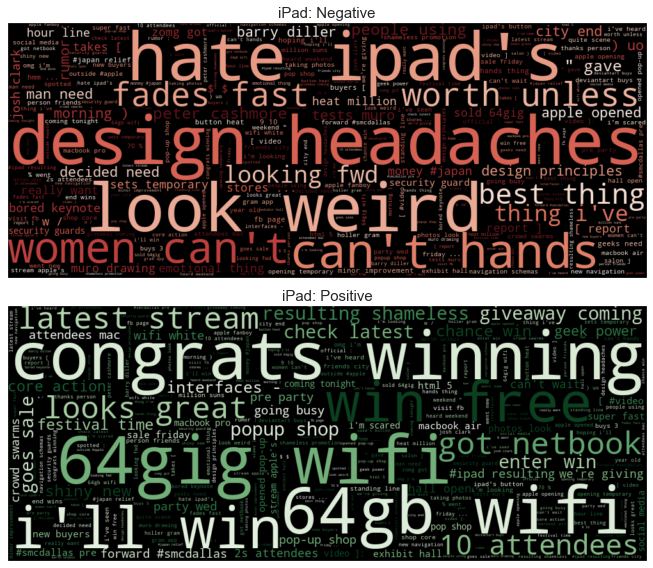

<IPython.core.display.Javascript object>

In [116]:
fig = plot_brand_clouds("iPad")

A lot of familiar phrases appear hear, like "design headaches" and "64gig wifi". I haven't seen "look weird" before, though.

In [117]:
read_tweets("look weird", brand="iPad")

|      | text                                                                                                |
|-----:|:----------------------------------------------------------------------------------------------------|
| 6189 | RT @mention It's official: people using the iPad 2 to take photos just look weird. #SXSW            |
| 2366 | It's official: people using the iPad 2 to take photos just look weird. #SXSW                        |
| 2711 | LOL 2 true RT @mention It's official: people using the iPad 2 to take photos just look weird. #SXSW |

<IPython.core.display.Javascript object>

These tweets say that people using the iPad 2 to take photos look weird. I can see that, because the iPad 2 is pretty large and unwieldy.

In [118]:
read_tweets("women can't", brand="iPad")

|      | text                                                                                                                     |
|-----:|:-------------------------------------------------------------------------------------------------------------------------|
| 8256 | In my next life I'm coming back as an iPad 2. Women can't keep their hands off this thing. #SXSW                         |
| 6131 | RT @mention In my next life I'm coming back as an iPad 2. Women can't keep their hands off this thing. #SXSW             |
| 6564 | RT @mention RT @mention In my next life I'm coming back as an iPad 2. Women can't keep their hands off this thing. #SXSW |

<IPython.core.display.Javascript object>

The phrase "women can't" actually comes from positive tweets.

In [119]:
read_tweets("hate the ipad's", brand="iPad")

|      | text                                                                                                                         |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------|
| 3311 | iPad design malady: iPad Elbow - I hate the iPad's back button with the heat of a million suns. #tapworthy #sxsw             |
| 6198 | RT @mention Josh Clark: I hate the iPad's back button with the heat of a million suns. #tapworthy #SXSW                      |
| 6155 | RT @mention iPad design malady: iPad Elbow - I hate the iPad's back button with the heat of a million suns. #tapworthy #sxsw |
| 3990 | Josh Clark: I hate the iPad's back button with the heat of a million suns. #tapworthy #SXSW                                  |

<IPython.core.display.Javascript object>

The phrase "hate ipad's" is related to Josh Clark's talk about iPad design challenges. He says he hates the iPad's back button "with the heat of a million suns." This is just one guy's opinion on a very specific design choice, but it's interesting.

In [120]:
read_tweets("worth it unless", brand="iPad")

|      | text                                                                                                                                    |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------|
| 7367 | @mention Peter Cashmore on the iPad 2: it's only a minor improvement. Not worth it unless you have money to burn. #SXSW                 |
| 4347 | just got mine & i disagree RT @mention Peter Cashmore on iPad 2 it's only a minor improvement Not worth it unless you've $ 2 burn #SXSW |
| 5145 | RT @mention @mention Peter Cashmore on the iPad 2: it's only a minor improvement. Not worth it unless you have money to burn. #SXSW     |

<IPython.core.display.Javascript object>

The phrase "worth unless" is related to Peter Cashmore's claim that the iPad 2 is only a minor improvement over the original iPad, and not worth the price. One person who bought an iPad 2 voices their disagreement.

In [121]:
read_tweets("congrats to @mention", brand="iPad")

|      | text                                                                                                                                  |
|-----:|:--------------------------------------------------------------------------------------------------------------------------------------|
| 8531 | Congrats to @mention another @mention winner of an #iPad case, it's going on a mission trip with his sister in Haiti! #SXSW #cbatsxsw |
| 3401 | Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw        |
| 8535 | Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw                                  |
| 8333 | I'm a captain penguin now! RT @mention congrats to @mention for getting to the next level in his fave iPad game PengAirborne #SXSWU   |
| 5641 | RT @mention Congrats to @mention for winning the Ipad 2 raffled at the #SmileyParty. Check your inbox for details! #sxsw              |

<IPython.core.display.Javascript object>

The positive phrase "congrats winning" is related to tweets congratulating someone who won an iPad case giveaway.

In [122]:
read_tweets("netbook", brand="iPad")

|      | text                                                                                                                                |
|-----:|:------------------------------------------------------------------------------------------------------------------------------------|
| 8816 | It's #SXSW Festival time... OMG I'm scared! Got my netbook, Firm's iPad and my droid!                                               |
| 1900 | LoL U r gadgetzilla! Have fun! @mention It's #SXSW Festival time. OMG I'm scared! Got my netbook, #iPad & my droid!                 |
| 2957 | YES RT @mention LoL U r gadgetzilla! Have fun! @mention It's #SXSW Festival time. OMG I'm scared! Got my netbook, #iPad & my droid! |

<IPython.core.display.Javascript object>

The phrase "got netbook" is related to tweets expressing excitement about the festival.

### Top iPhone Bigrams

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.45s/it]


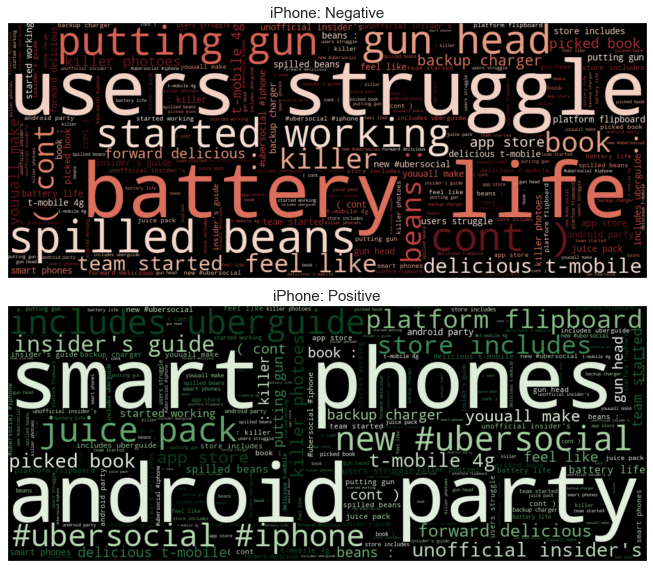

<IPython.core.display.Javascript object>

In [123]:
fig = plot_brand_clouds("iPhone")

In [124]:
read_tweets("battery life", brand="iPhone")

|      | text                                                                                                                                 |
|-----:|:-------------------------------------------------------------------------------------------------------------------------------------|
| 7671 | @mention Respectfully disagree about the iphone. Battery life is a problem and it isn't as ubiquitous as it seems. #project314 #sxsw |
| 1335 | Disgusted with my iPhone's battery life. Already down to 11% at 3:30 pm while my blackberry is going strong. #Sxsw                   |
| 8820 | This #SXSW I am grateful for: my bicycle, having a back-up Twitter app. Cursing: losing an hour of zzzs, iPhone battery life.        |
| 4397 | Just got my Mophie Juice Pack plus for my iPhone 4! Now I'm ready for #sxsw. More than double the battery life #FTW                  |
| 3121 | #sxsw is exposing my iphone's horrendous battery life.                                                                               |

<IPython.core.display.Javascript object>

As discovered in the EDA notebook, there are complaints about the iPhone's battery life. I think this is important feedback for Apple to consider.

In [125]:
read_tweets("gun to @mention head", brand="iPhone")

|      | text                                                                                               |
|-----:|:---------------------------------------------------------------------------------------------------|
| 7503 | @mention putting a gun to @mention head. Give me your iPhone! #SXSW {link}                         |
| 5146 | RT @mention @mention putting a gun to @mention head. Give me your iPhone! #SXSW {link}             |
| 6488 | RT @mention RT @mention @mention putting a gun to @mention head. Give me your iPhone! #SXSW {link} |

<IPython.core.display.Javascript object>

The "gun head" tweets appear to be related to a joke about stealing someone's iPhone. Negative, perhaps, but not really of concern to Apple.

In [126]:
read_tweets("spilled the beans", brand="iPhone")

|      | text                                                                                                                                             |
|-----:|:-------------------------------------------------------------------------------------------------------------------------------------------------|
| 6220 | So @mention just spilled the beans: next platform for Flipboard is the iPhone. Team started working on it. #sxflip #SXSW #SXSWi                  |
| 1089 | UI@mention So @mention just spilled the beans: next platform for Flipboard is the iPhone. Team started working on it. #sxflip #SXSW #SXSWiU Gr8! |
| 1632 | Woot! RT @mention So @mention just spilled the beans: next platform for Flipboard is the iPhone. Team started working on it. #sxflip #SXSW       |

<IPython.core.display.Javascript object>

The "spilled beans" tweets are actually positive, pertaining to the release of a Flipboard app for iPhone.

In [127]:
read_tweets("users struggle", brand="iPhone")

|      | text                                                                                                                      |
|-----:|:--------------------------------------------------------------------------------------------------------------------------|
| 7158 | Looking forward to delicious T-Mobile 4G here in Austin while iPhone users struggle to do anything. #SXSW                 |
| 5737 | RT @mention forward to delicious T-Mobile 4G here in Austin while iPhone users struggle to do anything. #SXSW             |
| 6529 | RT @mention RT @mention forward to delicious T-Mobile 4G here in Austin while iPhone users struggle to do anything. #SXSW |

<IPython.core.display.Javascript object>

The "users struggle" tweets are related to criticism of the iPhone's lackluster AT&T service, and the suggestion the T-Mobile is better. Presumably these are Android users.

In [128]:
read_tweets("android party", brand="iPhone")

|      | text                                                                                                           |
|-----:|:---------------------------------------------------------------------------------------------------------------|
| 2994 | Mega tether iPhone/Android party with @mention and @mention . #chargin2diffphonesatonce #dorkinout #sxsw       |
| 2465 | You should probably put that away... RT @mention at the Android party and kinda embarrassed by my iPhone #SXSW |
| 2565 | at the Android party and kinda embarrassed by my iPhone #SXSW                                                  |

<IPython.core.display.Javascript object>

The "android party" tweets are related to someone being embarrassed to have an iPhone at the Android party at Lustre Pearl. This seems pretty benign.

In [129]:
read_tweets("new #ubersocial", brand="iPhone")

|      | text                                                                                                                       |
|-----:|:---------------------------------------------------------------------------------------------------------------------------|
|   96 | Yai!!! RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by (cont) {link} |
| 3838 | Fuck the iphone! RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW ... {link}       |
| 1370 | @mention -> RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW (cont) {link}         |
| 6349 | RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW {link} Got it now                 |
| 3353 | Whoohoo! Got it! ;) RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW (cont) {link} |
| 1369 | @mention --> RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW ... {link}           |
| 6343 | RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable {link}     |
| 4220 | @mention look! RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW ... {link}         |

<IPython.core.display.Javascript object>

There's a lot of positive talk about the new UberSocial app for iPhone. There's also one very negative retweet about it.

### Top iOS App Bigrams

Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.00it/s]


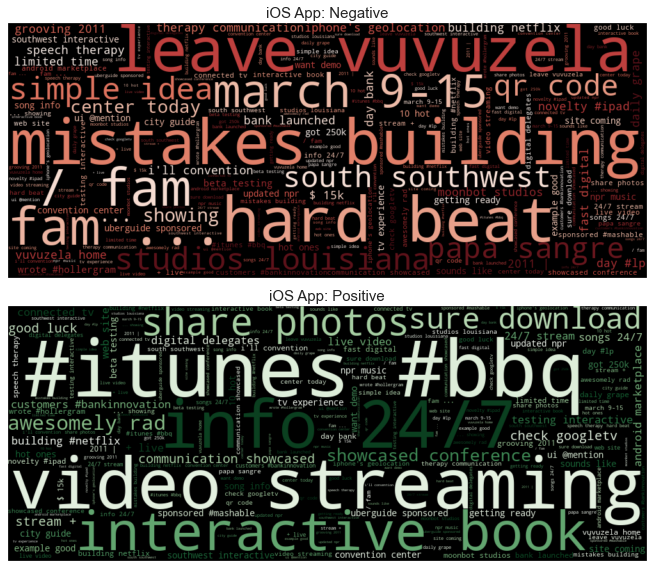

<IPython.core.display.Javascript object>

In [130]:
fig = plot_brand_clouds("iOS App")

In [131]:
read_tweets("mistakes", brand="iOS App")

|      | text                                                                                                                                     |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------|
| 3850 | @mention is about to talk about the mistakes he made building Netflix for the iPhone. #SXSW #netflixiphone                               |
| 1862 | @mention about to talk at #sxsw on mistakes building #Netflix #iphone app                                                                |
| 6274 | RT @mention Looks like this was a fun session at #SXSW: "Mistakes Made Building Nextflix for iPhone": {link}                             |
| 2735 | Looks like this was a fun session at #SXSW: "Mistakes Made Building Nextflix for iPhone": {link}                                         |
| 2352 | About to check out "mistakes I made building Netflix for iPhone." this is going to be cool -you should always learn from mistakes. #sxsw |
| 8098 | #SXSW: Mistakes Made Building Netflix for iPhone (Plus, How to See Its Source Code!) {link} via @mention                                 |

<IPython.core.display.Javascript object>

The phrase "mistakes building" is related to mistakes made building the Netflix app for iPhone. This is something I previously uncovered.

In [132]:
read_tweets("vuvuzela", brand="iOS App")

|      | text                                                                                                                |
|-----:|:--------------------------------------------------------------------------------------------------------------------|
| 8231 | Very smart from @mention #hollergram iPad app for #sxsw! {link} (may leave my vuvuzela at home now)                 |
|   30 | Very smart from @madebymany #hollergram iPad app for #sxsw! http://t.co/A3xvWc6 (may leave my vuvuzela at home now) |
| 6843 | RT @mention Very smart from @mention #hollergram iPad app for #sxsw! {link} (may leave my vuvuzela at home now)     |

<IPython.core.display.Javascript object>

The "leave vuvuzela" tweets are related to the Hollergram app, a custom social network app created for SXSW, 2011. The idea is that the app can be used to get people's attention and communicate, I think. There's nothing negative here.

In [133]:
read_tweets("hard to beat", brand="iOS App")

|      | text                                                                                                                       |
|-----:|:---------------------------------------------------------------------------------------------------------------------------|
| 5787 | RT @mention Going to #SXSW? The new iPhone guide to #Austin by @mention is free March 9-15. Hard to beat free. #lp #mobile |
| 1748 | Going to #SXSW? The new iPhone guide to #Austin by @mention is free March 9-15. Hard to beat free. #lp                     |
| 5786 | RT @mention Going to #SXSW? The new iPhone guide to #Austin by @mention is free March 9-15. Hard to beat free. #lp         |

<IPython.core.display.Javascript object>

The phrase "hard beat" is actually from positive tweets related to an LonelyPlanet's guide to Austin (an app). I've already uncovered similar tweets.

In [134]:
read_tweets("louisiana", brand="iOS App")

|      | text                                                                                                                    |
|-----:|:------------------------------------------------------------------------------------------------------------------------|
|  145 | UI@mention #sxsw beta testing interactive book for iPad app by Moonbot studios out of Louisiana. Cool app.U             |
| 5284 | RT @mention #sxsw beta testing interactive book for iPad app by Moonbot studios out of Louisiana. Cool app.             |
| 5063 | RT @mention UI@mention #sxsw beta testing interactive book for iPad app by Moonbot studios out of Louisiana. Cool app.U |
| 1847 | #sxsw beta testing interactive book for iPad app by Moonbot studios out of Louisiana. Cool app.                         |

<IPython.core.display.Javascript object>

The "studios louisiana" phrase is related to tweets about an interactive book app by Moonbot Studios. These are positive tweets, which also contain the positive phrase "interactive book."

In [135]:
read_tweets("papa sangre", brand="iOS App")

|      | text                                                                                                              |
|-----:|:------------------------------------------------------------------------------------------------------------------|
| 8269 | First, get Papa Sangre on the iPhone. Their panel was amazing and the game is totally awesome. #sxsw #sxswi       |
| 6435 | RT @mention Papa Sangre, an immersive audio game for IPhone, is free today. Highly recommended. #PapaSangre #SxSW |
| 7637 | Papa Sangre, an immersive audio game for IPhone, is free today. Highly recommended. #PapaSangre #SxSW             |

<IPython.core.display.Javascript object>

The phrase "papa sangre" is the title of a well-liked game for iPhone which was free one day during the festival. These are actually positive tweets. The phrase was most likely judged negative because of the term "sangre," which is Spanish for "blood."

In [136]:
read_tweets("video streaming", brand="iOS App")

|      | text                                                                                                                                      |
|-----:|:------------------------------------------------------------------------------------------------------------------------------------------|
| 2824 | Our updated iPhone app has song info for select streams (incl. @mention 24/7) & live video streaming in time for #SXSW {link}             |
| 6985 | RT @mention YES! updated #iPhone app has song info @mention 24/7 stream +others also live video streaming for #SXSW {link}                |
| 6986 | RT @mention YES! updated iPhone app has song info @mention 24/7 stream +others also live video streaming for #SXSW {link}                 |
| 8374 | YES! updated iPhone app has song info @mention 24/7 stream +others also live video streaming for #SXSW {link}                             |
| 6630 | RT @mention RT @mention YES! updated iPhone app has song info @mention 24/7 stream +others also live video streaming for #SXSW {link}     |
| 6832 | RT @mention Updated NPR Music iPhone app has song info for All Songs 24/7 & live video streaming just in time for #SXSW {link}            |
| 6425 | RT @mention Our updated iPhone app has song info for select streams (incl. @mention 24/7) & live video streaming in time for #SXSW {link} |
| 7780 | So cool! RT @mention Updated NPR Music iPhone app song info 4 All Songs 24/7 & live video streaming in time 4 #SXSW {link}                |
| 7463 | Updated NPR Music iPhone app has song info for All Songs 24/7 & live video streaming just in time for #SXSW {link}                        |

<IPython.core.display.Javascript object>

The phrases "video streaming" and "info 24/7" come from tweets celebrating the updated NPR Music app for iPhone.

In [137]:
read_tweets(r"#itunes.*#bbq", brand="iOS App")

|      | text                                                                                                                         |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------|
| 1050 | Congrats! RT @mention Good News! Austin Eats: BBQ for iPhone is now available - {link} #iTunes #Austin #BBQ #SXSW #SXSWi     |
| 5795 | RT @mention Good News! Austin Eats: BBQ for iPhone is now available - {link} #iTunes #Austin #BBQ #SXSW #SXSWi /via @mention |
| 5794 | RT @mention Good News! Austin Eats: BBQ for iPhone is now available - {link} #iTunes #Austin #BBQ #SXSW #SXSWi               |
| 1442 | Good News! Austin Eats: BBQ for iPhone is now available - {link} #iTunes #Austin #BBQ #SXSW #SXSWi                           |

<IPython.core.display.Javascript object>

The hashtag combination "#itunes #bbq" comes from tweets promoting the iPhone app, "Austin Eats: BBQ."

In [138]:
read_tweets(r"share photos", brand="iOS App")

|      | text                                                                                                                                             |
|-----:|:-------------------------------------------------------------------------------------------------------------------------------------------------|
| 4464 | RT@mention What's going on at #sxsw today? Share photos, video with iReport: {link} or through #CNN iPhone app!                                  |
| 8896 | @mention What's going on at #sxsw today? Share photos, video with iReport: {link} or through CNN iPhone app!                                     |
| 7698 | On the Early #nerdbird to #SXSW - get @mention iPhone app. Share photos of airport people. Like people of Wal-Mart, but at airports!             |
| 6410 | RT @mention On the Early #nerdbird to #SXSW - get @mention iPhone app. Share photos of airport people. Like people of Wal-Mart, but at airports! |

<IPython.core.display.Javascript object>

The phrase "share photos" seems to come from positive tweets promoting two different apps which support photo sharing.

# Recommendations

See [exploratory.ipynb](exploratory.ipynb) for more of the investigation which led to my recommendations.

#### 1. Try to shake your authoritarian image by ostensibly allowing end-users more freedom.

People like that Apple products just work out of the box, but they find your paternalistic approach to managing your products off-putting. Send the message that when you buy an Apple product, you are free to do what you want with it. Keep control over the most important things, but relinquish control over the less important things. Make people feel like they have the freedom to customize your products as they see fit. Make some concessions to placate the majority, while allowing the elite techno-snobs to continue complaining on the fringe.

#### 2. Do something to improve the iPhone's battery life and turn it into a marketing campaign.

There were a lot complaints about the iPhone's battery life. One user suggested that their Blackberry was doing much better. There were also complaints about #batterykiller apps which use geolocation in the background. If you made a big publicized effort to increase the iPhone's battery life, that would get people excited.

#### 3. Open another temporary popup store for your next big product launch.

The iPad 2 popup store was a roaring success, and people couldn't stop talking about it. Terms like 'shiny new', 'jealous', and 'cool technology' were closely associated with the iPad 2 and popup store.

#### 4. Provide free refreshments at your events.

There was a lot of excitement about the free food and drinks Google offered at their party. Free refreshments go a long way to generate good will, so I recommend providing them at at least some of your events.

# Future Work

### Stacking Classifiers

After experimenting a little with Scikit-Learn's `StackingClassifier`, it's clear to me that I could develop a more accurate conventional model this way. The `StackingClassifier` trains several classifiers on the data and then trains a final classifier on the concatenated output of those classifiers. It also allows you to pass the training data to your final estimator, so the final estimator is trained both on prior data and the predictions of the classifier ensemble.

### Bertweet

A [variant](https://huggingface.co/transformers/model_doc/bertweet.html) of BERT exists which is designed specifically for English tweets. I have not had a chance to try it yet, but I suspect it could outperform my final model.

# Conclusion

I created an accurate model, at around 93% accuracy. The dataset is small, noisy, and not particularly well labeled. Nevertheless, I'm confident that I can increase the accuracy by using Bertweet.

Through interpreting my model and conducting exploratory analysis in [exploratory.ipynb](exploratory.ipynb), I arrived at four recommendations. First, you should publicly relinquish a small amount of control over your products to send the message that you care about individual freedom (and aren't a "fascist company"). Second, you should improve the iPhone's battery life and turn that into a rallying point for a marketing campaign. People are really concerned about the iPhone's battery life. Third, you should repeat the temporary popup store for your next big product launch. There was an overwhelming amount of chatter about the iPad 2 popup store. And fourth, you should provide free refreshments at some of your events.